In [1]:
import os,sys,glob
# Move two levels up work from project level, not location of analysis file
os.chdir('../..')
print(os.getcwd())
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import Functions.globalFunctions.ExtracellularField as EcF
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from typing import Literal
from scipy import integrate
import ipympl
import time
import seaborn as sns
from scipy import stats
from scipy import optimize
#import warnings
from Analyses.SDC_singlePulse_singleOpticField.tools import *
from Analyses.SDC_singlePulse_singleOpticField import loader

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
#warnings.filterwarnings('error',category=UserWarning)

%matplotlib inline
recollect = False

font = {'family': 'helvetica',
        'size': 10}
mpl.rc('font', **font)
linestyle_str = ['solid', 'dotted', 'dashed', 'dashdot']
cmap_tab20 = np.array(mpl.cm.get_cmap('tab20').colors)
def myfun(x, y): return list(mpl.colors.to_rgb(x))+[y]
colorkeyval = {'soma': myfun('tab:red', 1), 'axon': myfun('tomato', 1), 'apic': myfun('seagreen', 1),
                'basaldend': myfun('teal', 1), 'alldend': myfun('tab:cyan',1), 'allsec': myfun('tab:blue', 1),
                'pyr_1': list(cmap_tab20[2,:])+[1],'pyr_2': list(cmap_tab20[3,:])+[1],
                'bc_1': list(cmap_tab20[8,:])+[1],'bc_2': list(cmap_tab20[9,:])+[1], 'unclassified': [0, 0, 0]}

d:\Users\rschoete\Documents\Optogenetics\OptogeneticExcitability\Code


In [2]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    if not cbar_kw is False:
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def heatmap2(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="",row_colors = None, column_colors = None, labelfs = 10, lw_grid=1, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)
    if row_colors is not None:
        ax_row_cols = ax.inset_axes([-0.01, 0, 0.01, 1])
        ax_row_cols.spines[:].set_visible(False)
    if column_colors is not None:
        ax_column_cols = ax.inset_axes([0,1, 1, 0.01,])
        ax_column_cols.spines[:].set_visible(False)



    # Create colorbar
    if not cbar_kw is False:
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize=labelfs)

    # Show all ticks and label them with the respective list entries.
    if column_colors is None:
        ax.set_xticks(np.arange(data.shape[1]), labels=col_labels,fontsize=labelfs)
        # Let the horizontal axes labeling appear on top.
        ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=-45, ha="right",
             rotation_mode="anchor")

    else:
        ax_column_cols.imshow(column_colors,aspect='auto')
        ax_column_cols.set_xticks(np.arange(data.shape[0]), labels=col_labels,fontsize=labelfs)
        ax_column_cols.set_xticks(np.arange(data.shape[0]+1)-.5, minor=True)
        ax_column_cols.set_yticks([])
        ax_column_cols.tick_params(which="minor", bottom=False, left=False)
        ax.set_xticks([])
        # Let the horizontal axes labeling appear on top.
        ax_column_cols.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
        # Rotate the tick labels and set their alignment.
        plt.setp(ax_column_cols.get_xticklabels(), rotation=-45, ha="right",
             rotation_mode="anchor")

    if row_colors is None:
        ax.set_yticks(np.arange(data.shape[0]), labels=row_labels,fontsize=labelfs)
        ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    else:
        ax_row_cols.imshow(row_colors,aspect='auto')
        ax_row_cols.set_yticks(np.arange(data.shape[0]), labels=row_labels,fontsize=labelfs)
        ax_row_cols.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
        ax_row_cols.set_xticks([])
        ax_row_cols.tick_params(which="minor", bottom=False, left=False)

        ax.set_yticks([])
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.grid(which="minor", color="w", linestyle='-', linewidth=lw_grid)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar
def sort_xy_based_x(x,y):
    x = np.array(x)
    y = np.array(y)
    sort_idx = np.argsort(x)
    x = x[sort_idx]
    y = y[sort_idx]
    return x,y

def modify_plot(*args, **kwargs):
    if "ax" in kwargs:
      ax = kwargs['ax']
    else:
      ax = plt.gca()
    xpoints = ypoints = ax.get_xlim()
    ax.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, scalex=False, scaley=False)

def broken_boxplot(df,break_points, yaxratio=1, fig = None,**boxplot_kwargs):
    if fig is None:
        fig = plt.figure()
    if yaxratio==1:
        ax1, ax2 = fig.subplots(2, 1, sharex=True)
    else:
        gs = fig.add_gridspec(2, 1, height_ratios=(1, yaxratio))
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1], sharex=ax1)
    fig.subplots_adjust(hspace=0.05)  # adjust space between axes

    # plot the same data on both axes
    sns.boxplot(df,ax=ax1,**boxplot_kwargs)
    sns.boxplot(df,ax=ax2,**boxplot_kwargs)
    ylims = ax1.get_ylim()
    # zoom-in / limit the view to different portions of the data
    ax1.set_ylim(break_points[1], ylims[1])  # outliers only
    ax2.set_ylim(ylims[0], break_points[0]) # most of the data

    # hide the spines between ax and ax2
    ax1.spines.bottom.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax1.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()

    # Now, let's turn towards the cut-out slanted lines.
    # We create line objects in axes coordinates, in which (0,0), (0,1),
    # (1,0), and (1,1) are the four corners of the axes.
    # The slanted lines themselves are markers at those locations, such that the
    # lines keep their angle and position, independent of the axes size or scale
    # Finally, we need to disable clipping.

    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0], [0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0], [1], transform=ax2.transAxes, **kwargs)
    return fig, ax1, ax2
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))].copy()
   return outliers, IQR

def EET_indices(r:int, xmin:np.ndarray, xmax:np.ndarray, X:np.ndarray, Y:np.ndarray, design_type:Literal['radial', 'trajectory'], Nboot:int=1, alfa:float=0.05):
    '''
    Compute the sensitivity indices according to the Elementary Effects Test
    (Saltelli, 2008) or 'method of Morris' (Morris, 1991).
    These are: the mean (mi) of the EEs associated to input 'i',
    which measures the input influence; and the standard deviation (sigma)
    of the EEs, which measures its level of interactions with other inputs.

    Basic usage:
    [mi, sigma, EE] = EET_indices(r,xmin,xmax,X,Y,design_type)

    Input:
        r = number of sampling point                           - scalar
        xmin = lower bounds of input ranges                 - vector (1,M)
        xmax = upper bounds of input ranges                 - vector (1,M)
        X = matrix of sampling datapoints where EE must be computed
                                                        - matrix (r*(M+1),M)
        Y = associated output values               - vector (r*(M+1),1)
        design_type = design type (string)
                [options: 'radial','trajectory']
    Output:
        mi = mean of the elementary effects               - vector (1,M)
        sigma = standard deviation of the elementary effects - vector (1,M)
        EE = matrix of elementary effects                 - matrix (r,M)


    Advanced usage:

    [mi, sigma, EE] = EET_indices(r,xmin,xmax,X,Y,design_type,Nboot)
    [mi, sigma, EE] = EET_indices(r,xmin,xmax,X,Y,design_type,Nboot,alfa)

    Optional input:
        Nboot = number of resamples used for boostrapping (default:0)
        alfa = significance level for the confidence intervals estimated
                by bootstrapping (default: 0.05)
    In this case, the output 'mi' and 'sigma' are the mean and standard
    deviation of the EEs averaged over Nboot resamples.

    Advanced usage/2:

    [mi, sigma, EE, mi_sd, sigma_sd, mi_lb, sigma_lb, mi_ub, sigma_ub] = ...
                EET_indices(r,xmin,xmax,X,Y,design_type,Nboot)

    Optional output:
        mi_sd = standard deviation of 'mi' across Nboot resamples
        sigma_sd = standard deviation of 'sigma' across Nboot resamples
        mi_lb = lower bound of 'mi' (at level alfa) across Nboot resamples
        sigma_lb = lower bound of 'sigma' across Nboot resamples
        mi_ub = upper bound of 'mi' (at level alfa) across Nboot resamples
        sigma_ub = upper bound of 'sigma' across Nboot resamples
                                                    - all the above are
                                                    vector (1,M) if Nboot>1
                                                    (empty vector otherwise)
    Or:

    [mi, sigma, EE, mi_sd, sigma_sd, mi_lb, sigma_lb, mi_ub, sigma_ub, ...
        mi_all, sigma_all ] = EET_indices(r,xmin,xmax,X,Y,design_type,Nboot)

    Optional output:
        mi_all = Nboot estimates of 'mi'                    - matrix (Nboot,M)
        sigma_all = Nboot estimates of 'sigma'                 - matrix (Nboot,M)

    REFERENCES:

    Morris, M.D. (1991), Factorial sampling plans for preliminary
    computational experiments, Technometrics, 33(2).

    Saltelli, A., et al. (2008) Global Sensitivity Analysis, The Primer,
    Wiley.

    This function is part of the SAFE Toolbox by F. Pianosi, F. Sarrazin
    and T. Wagener at Bristol University (2015).
    SAFE is provided without any warranty and for non-commercial use only.
    For more details, see the Licence file included in the root directory
    of this distribution.
    For any comment and feedback, or to discuss a Licence agreement for
    commercial use, please contact: francesca.pianosi@bristol.ac.uk
    For details on how to cite SAFE in your publication, please see:
    bristol.ac.uk/cabot/resources/safe-toolbox/
    '''

    ## Input check
    if not isinstance(r,int):
        raise ValueError("r should be integer")
    if np.ndim(xmin)!=1 or  np.ndim(xmax)!=1:
        raise ValueError("xmax must be a row vector")
    if len(xmin)!=len(xmax):
        raise ValueError("xmin should have same length as xmax")

    Dr = xmax - xmin

    if any(Dr<0):
        raise ValueError("all components of ''xmax'' must be higher than the corresponding ones in xmin")
    M = len(Dr)
    n,m = np.shape(X)
    if n!=r*(M+1):
        raise ValueError("X must have r*(M+1) rows")
    if m!=M:
        raise ValueError("X must have M columns")
    if np.ndim(Y)!=1:
        raise ValueError("Y must be 1 dim array")
    n = np.size(Y)
    if n!=r*(M+1):
        raise ValueError("Y must have r*(M+1) rows")

    ## EET calculation

    M = X.shape[1]
    EE = np.full((r, M), np.nan)  # matrix of elementary effects
    k = 0
    ki = 0
    for i in range(r):
        for j in range(M):
            if design_type == 'radial':  # radial design: EE is the difference
                # between output at one point in the i-th block and output at
                # the 1st point in the block
                dy = abs(Y[k + 1] - Y[ki])
                dx = abs(X[k + 1, j] - X[ki, j])
                EE[i, j] = dy/ dx * Dr[j]
            elif design_type == 'trajectory':  # trajectory design: EE is the difference
                # between output at one point in the i-th block and output at
                # the previous point in the block (the "block" is indeed a
                # trajectory in the input space composed of points that
                # differ in one component at the time)
                idx = np.where(abs(X[k + 1, :] - X[k, :]) > 0)[0]  # if using 'morris'
                # sampling, the points in the block may not
                # be in the proper order, i.e. each point in the block differs
                # from the previous/next one by one component but we don't know
                # which one; this is here computed and saved in 'idx'
                if len(idx) == 0:
                    raise ValueError(f"X({k},:) and X({k+1},:) are equal")
                if len(idx) > 1:
                    raise ValueError(f"X({k},:) and X({k+1},:) differ in more than one component")
                EE[i, idx] = abs(Y[k + 1] - Y[k]) / abs(X[k + 1, idx] - X[k, idx]) * Dr[idx]
            else:
                raise ValueError("'design_type' must be one among {'radial','trajectory'}")
            k += 1
        k += 1
        ki = k

    if Nboot > 1:
        bootsize = r
        B = np.floor((np.random.rand(bootsize,Nboot)*r)).astype(int)
        mi_all = np.empty((Nboot,M))
        sigma_all = np.empty((Nboot,M))
        for n in range(Nboot):
            mi_all[n,:] = np.mean(EE[B[:,n],:], axis=0)
            sigma_all[n,:] = np.std(EE[B[:,n],:], axis=0)

        mi = np.mean(mi_all, axis=0)
        mi_sd = np.std(mi_all, axis=0)
        mi_lb = np.sort(mi_all, axis=0)[max(1,round(Nboot*alfa/2))-1,:]
        mi_ub = np.sort(mi_all, axis=0)[round(Nboot*(1-alfa/2))-1,:]

        sigma = np.mean(sigma_all, axis=0)
        sigma_sd = np.std(sigma_all, axis=0)
        sigma_lb = np.sort(sigma_all, axis=0)[max(1,round(Nboot*alfa/2))-1,:]
        sigma_ub = np.sort(sigma_all, axis=0)[round(Nboot*(1-alfa/2))-1,:]

        return mi, sigma, EE, mi_sd, sigma_sd, mi_lb, sigma_lb, mi_ub, sigma_ub, mi_all, sigma_all
    else:
        mi = np.mean(EE, axis=0)
        sigma = np.std(EE, axis=0)
        return mi, sigma, EE

def EET_plot(mi,sigma,labels,mi_lb=None,mi_ub=None,sigma_lb=None,sigma_ub=None,clrs=None,cc=None, ax=None, ms=14):
    if ax is None:
        plt.figure()
        ax = plt.gca()
    if clrs is None:
        clrs = list(mpl.colors.TABLEAU_COLORS.values())
    if isinstance(clrs,dict):
        clrs_dict = clrs
        clrs = []
        for l in labels:
            clrs.append(clrs_dict[l])
    # First plot EEs mean & std as circles:
    for m,s,label,clr in zip(mi, sigma, labels,clrs):
        ax.plot(m,s,'ok',markerfacecolor=clr,markersize=ms,markeredgecolor='k',zorder=1, label=label)
    if not (mi_lb is None or mi_ub is None or sigma_lb is None or sigma_ub is None):

        #plot first the larger confidence areas
        size_bounds=mi_ub-mi_lb
        idx = np.argsort(size_bounds)[::-1]

        for i in range(len(idx)):  # add rectangular shade:
            h = ax.fill([mi_lb[idx[i]],mi_lb[idx[i]],mi_ub[idx[i]],mi_ub[idx[i]]],[sigma_lb[idx[i]],sigma_ub[idx[i]],sigma_ub[idx[i]],sigma_lb[idx[i]]],facecolor=clrs[idx[i]],edgecolor='none',zorder=0)

        # Plot again the circles (in case some have been overriden by the rectangles
        # representing confidence bounds)
        for m,s,label,clr in zip(mi, sigma, labels, clrs):
            ax.plot(m,s,'ok',markerfacecolor=clr,markersize=ms,markeredgecolor='k',zorder=1, label=label)

# Loading data

In [3]:
# Load data
filepath = './Results/SDC/SDC_EETUgent470grayinvivo_singlePulse'
filename = 'all_data_filled.csv'
drop_columns = ['opsinmech','distribution','distribution_method','seed','celsius','dt']


# opsinlocations to single word
opsinLocation_map = loader.opsinLocation_map
master_df = pd.read_csv(os.path.join(filepath, filename), index_col=0)
master_df['amp'] = master_df['amp']/1000 # convert W/m2 -> mW/mm2
for x in ['x','y','z']:
    for suffix in ['','_0']:
        master_df[x+suffix] = master_df[x+suffix]/1000 #convert um -> mm
master_df['TAC']=-master_df['ichr2']/master_df['dur']*1e-5 # convert to uA (ichr2: mA/cm2*um2)
master_df['Gmax'] = np.round(master_df['Gmax'],4)
master_df['theta_0'] = np.round(master_df['theta_0'],2)
for x in ['amp','Gmax','TAC','dur']:
    master_df[x+'_log10'] = np.round(np.log10(master_df[x]),4)

master_df = master_df.drop(drop_columns,axis=1)
master_df['neurontemplate'] = master_df['neurontemplate'].replace({'CA1_PC_cAC_sig5':'pyr_1', 'CA1_PC_cAC_sig6':'pyr_2', 'cNACnoljp1':'bc_1', 'cNACnoljp2':'bc_2'})
master_df[['celltype','cell_number']] = master_df['neurontemplate'].str.split('_',expand=True)
master_df['cluster_eet'] = master_df['EETsimidx']//7
master_df['idx_incluster_eet'] = master_df['EETsimidx']%7
all_columns=master_df.columns


all_settings_columns = ['dur', 'Gmax', 'EETsimidx', 'neurontemplate', 'theta_0','cluster_eet', 'idx_incluster_eet']

# change perspective from optrode centered to stratum pyramidale centred
for theta in master_df['theta_0'].unique():
    if theta<0:
        label = 'z'
        master_df.loc[master_df['theta_0']==theta,label]*=-1
        master_df.loc[master_df['theta_0']==theta,label+'_0']*=-1
    elif theta==0:
        label = 'x'
        master_df.loc[master_df['theta_0']==theta,label]*=-1
        master_df.loc[master_df['theta_0']==theta,label+'_0']*=-1
        toz = master_df.loc[master_df['theta_0']==theta,'x'].to_numpy()
        tox = master_df.loc[master_df['theta_0']==theta,'z'].to_numpy()
        toz_0 = master_df.loc[master_df['theta_0']==theta,'x_0'].to_numpy()
        tox_0 = master_df.loc[master_df['theta_0']==theta,'z_0'].to_numpy()
        master_df.loc[master_df['theta_0']==theta,'x'] = tox
        master_df.loc[master_df['theta_0']==theta,'z'] = toz
        master_df.loc[master_df['theta_0']==theta,'x_0'] = tox_0
        master_df.loc[master_df['theta_0']==theta,'z_0'] = toz_0

    master_df.loc[master_df['theta_0']==theta,'z']=np.round(master_df.loc[master_df['theta_0']==theta,'z']+master_df.loc[master_df['theta_0']==theta,'z_0'],3)
    master_df.loc[master_df['theta_0']==theta,'x']=np.round(master_df.loc[master_df['theta_0']==theta,'x']+master_df.loc[master_df['theta_0']==theta,'x_0'],3)


unique_values_columns_master = {key: master_df[key].unique() for key in all_columns}
for x in ['amp','Gmax','TAC','dur']:
    unique_values_columns_master[x] = np.sort(unique_values_columns_master[x])
    unique_values_columns_master[x+'_log10'] = np.sort(unique_values_columns_master[x+'_log10'])
for x in ['x', 'z', 'x_0', 'z_0']:
    unique_values_columns_master[x] = np.sort(unique_values_columns_master[x])
print('all coluumn names:\n\t',all_columns.to_numpy())
print('all settings:\n\t',all_settings_columns)
print('Total number of entries:\n\t',len(master_df))
for k in all_settings_columns+[x for x in all_columns if '_eet' in x]+['opsinlocations']:
    print(f'unique entries {k}:\n\t', len(unique_values_columns_master[k]),': ', unique_values_columns_master[k])
master_df.describe()

all coluumn names:
	 ['amp' 'sR' 'ichr2' 'gchr2' 'dur' 'field' 'nPulse' 'Gmax' 'opsinlocations'
 'x' 'y' 'z' 'phi' 'theta' 'psi' 'phi_0' 'theta_0' 'psi_0'
 'neurontemplate' 'x_0' 'y_0' 'z_0' 'EETsimidx' 'mua_eet' 'mus_eet'
 'g_eet' 'Gmax_eet' 'cell_eet' 'loc_eet' 'roll_eet' 'TAC' 'amp_log10'
 'Gmax_log10' 'TAC_log10' 'dur_log10' 'celltype' 'cell_number'
 'cluster_eet' 'idx_incluster_eet']
all settings:
	 ['dur', 'Gmax', 'EETsimidx', 'neurontemplate', 'theta_0', 'cluster_eet', 'idx_incluster_eet']
Total number of entries:
	 406560
unique entries dur:
	 5 :  [  1.           3.16227766  10.          31.6227766  100.        ]
unique entries Gmax:
	 21 :  [0.7699 0.8274 0.8669 0.8835 0.8988 0.9131 0.9267 0.9522 0.9764 0.9882
 1.     1.0236 1.0356 1.0478 1.0733 1.0869 1.1012 1.1331 1.1726 1.2301
 1.2794]
unique entries EETsimidx:
	 112 :  [  0   1  10 100 101 102 103 104 105 106 107 108 109  11 110 111  12  13
  14  15  16  17  18  19   2  20  21  22  23  24  25  26  27  28  29   3
  30  31 

amp        sR          ichr2          gchr2            dur  \
count  322685.000000  322685.0  406560.000000  406560.000000  406560.000000   
mean      904.470066       1.0   -1954.106700       0.744501      29.157011   
std      1652.553802       0.0    2210.411102      48.088487      37.041492   
min         0.026295       1.0  -21654.950300  -22159.528300       1.000000   
25%        46.649223       1.0   -2848.945300       0.027310       3.162278   
50%       222.773267       1.0   -1230.492950       0.150500      10.000000   
75%       900.900960       1.0    -654.267975       0.796000      31.622777   
max     12109.375000       1.0      -0.055660    6255.707300     100.000000   

         nPulse           Gmax              x         y              z  ...  \
count  406560.0  406560.000000  406560.000000  406560.0  406560.000000  ...   
mean        1.0       0.996246       1.333333       0.0       0.150000  ...   
std         0.0       0.125313       1.124230       0.0       0.347851  ...   
min         1.0       0.769900      -1.000000       0.0      -0.400000  ...   
25%         1.0       0.909525       0.500000       0.0      -0.180000  ...   
50%         1.0       0.994100       1.250000       0.0       0.150000  ...   
75%         1.0       1.076700       2.000000       0.0       0.480000  ...   
max         1.0       1.279400       4.000000       0.0       0.700000  ...   

            cell_eet        loc_eet       roll_eet           TAC  \
count  406560.000000  406560.000000  406560.000000  4.065600e+05   
mean        0.500000       5.455357       3.245027  3.651839e-03   
std         0.500001       3.231789       1.754237  7.626726e-03   
min         0.000000       0.000000       0.196350  3.976700e-07   
25%         0.000000       2.750000       1.570796  3.552877e-04   
50%         0.500000       5.500000       3.337942  8.248242e-04   
75%         1.000000       8.000000       4.810564  3.769477e-03   
max         1.000000      11.000000       5.890486  8.759367e-02   

           amp_log10     Gmax_log10      TAC_log10      dur_log10  \
count  322685.000000  406560.000000  406560.000000  406560.000000   
mean        2.239782      -0.005100      -3.123869       1.000000   
std         0.988420       0.054941       0.949016       0.707108   
min        -1.580100      -0.113600      -6.400500       0.000000   
25%         1.668800      -0.041200      -3.449400       0.500000   
50%         2.347900      -0.002600      -3.083600       1.000000   
75%         2.954700       0.032075      -2.423700       1.500000   
max         4.083100       0.107000      -1.057500       2.000000   

         cluster_eet  idx_incluster_eet  
count  406560.000000      406560.000000  
mean        7.500000           3.000000  
std         4.609778           2.000002  
min         0.000000           0.000000  
25%         3.750000           1.000000  
50%         7.500000           3.000000  
75%        11.250000           5.000000  
max        15.000000           6.000000  

[8 rows x 34 columns]

In [4]:
myselection = {'celltype':'pyr', 'cluster_eet': 0, 'dur':10}
intm_df = master_df[selection_generator(master_df,unique_values_columns_master,verbose=False,**myselection)]
print_upscale = False
nan_tolerance_percentage = 0.95


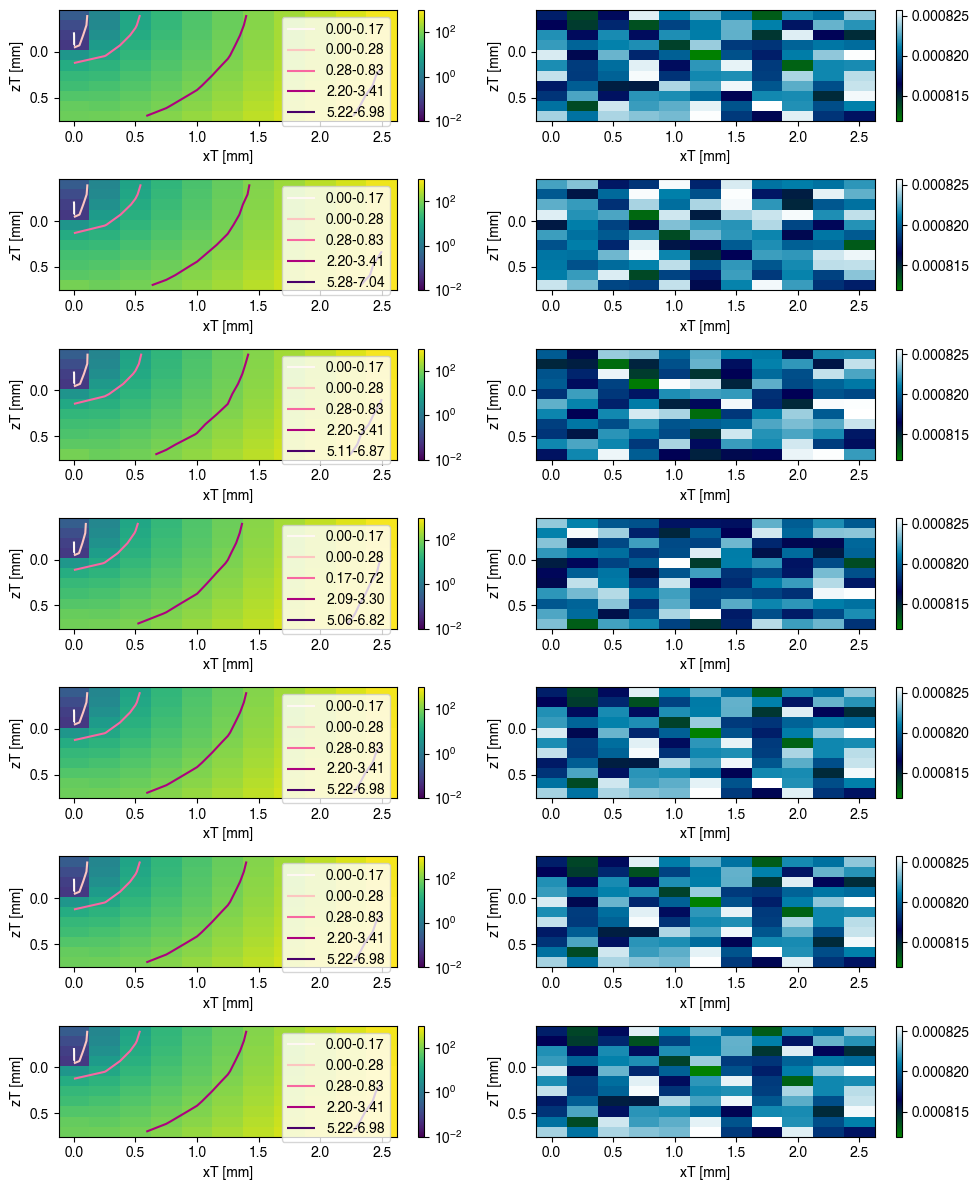

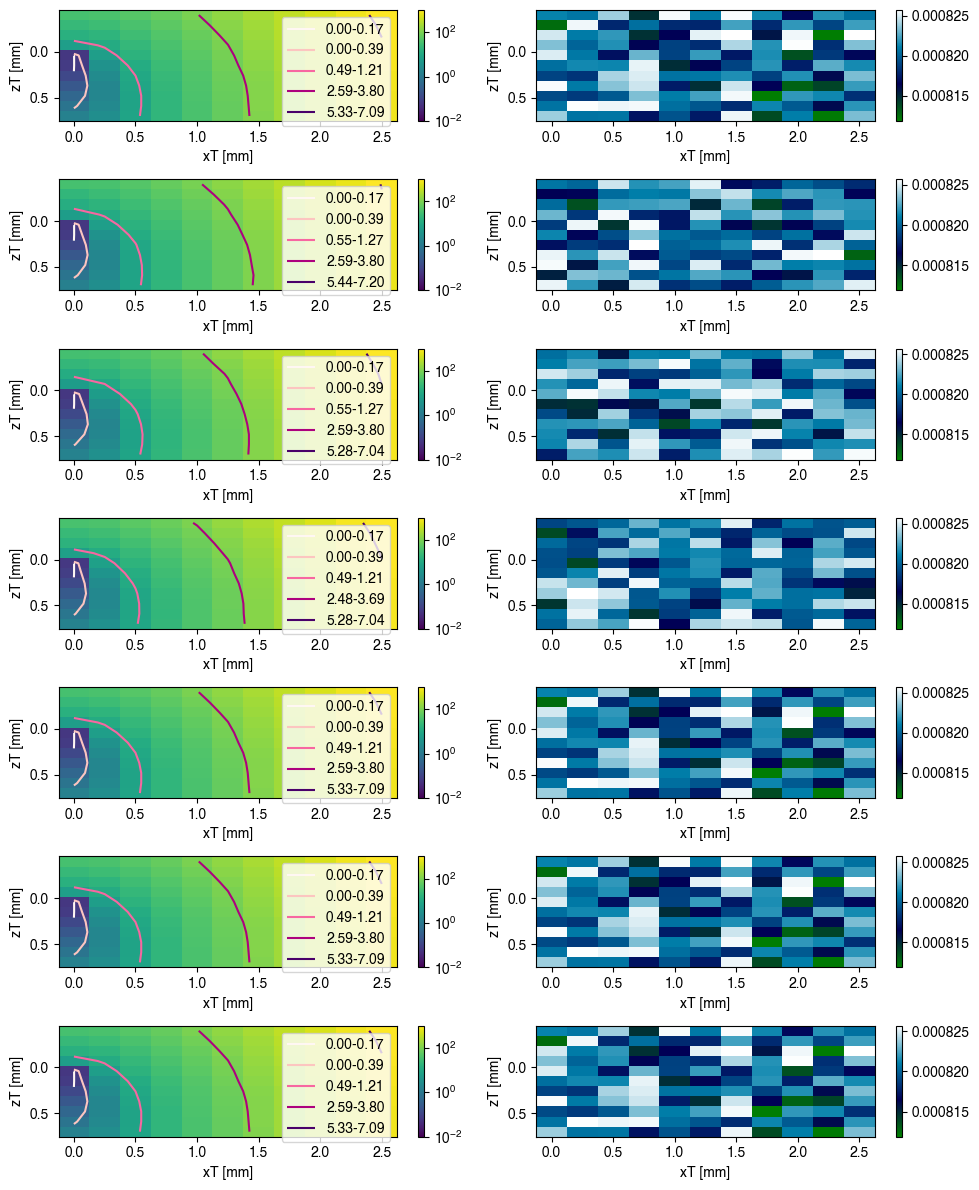

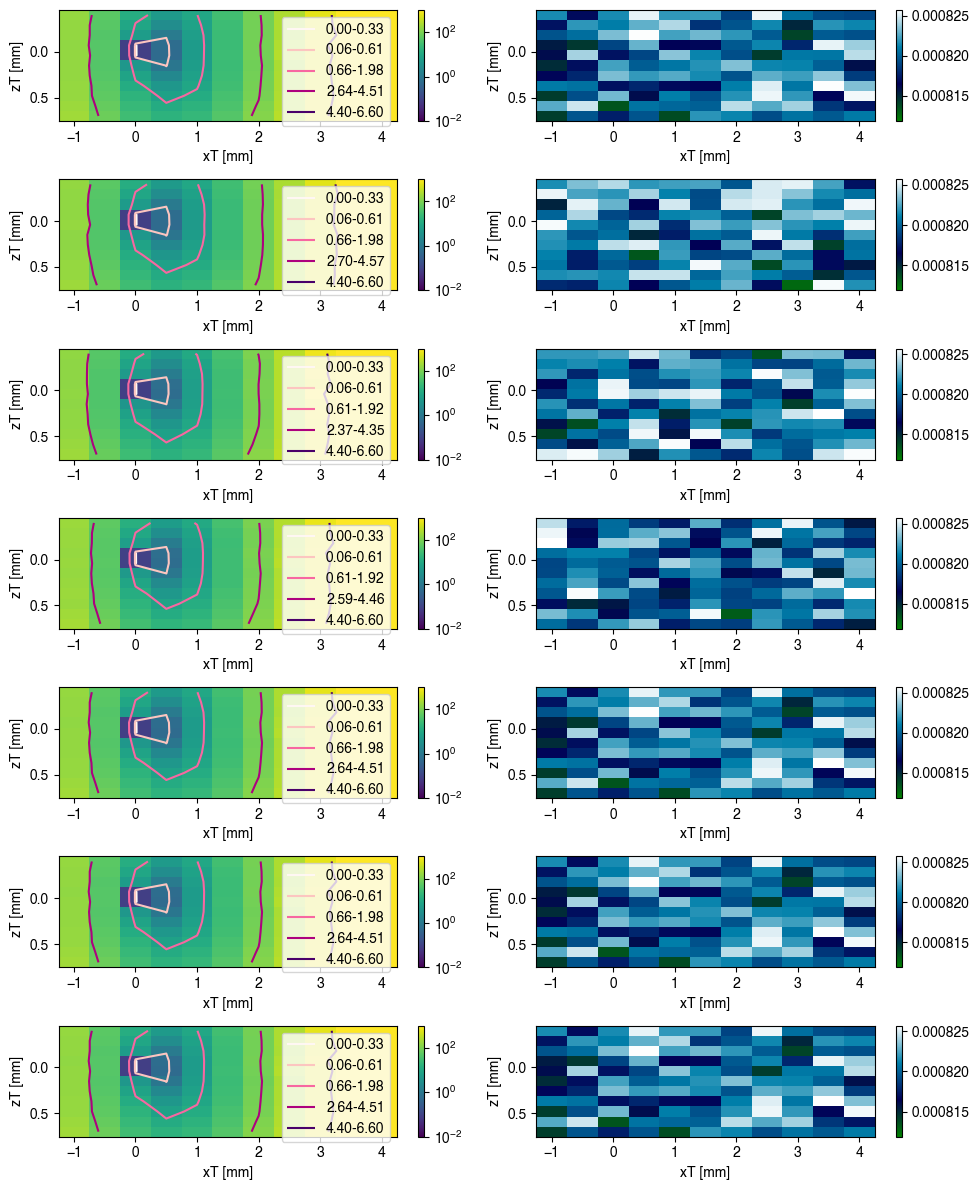

In [5]:


for theta in unique_values_columns_master['theta_0']:
    uiice = intm_df['idx_incluster_eet'].unique()
    fig,axs = plt.subplots(len(uiice),2,tight_layout = True,figsize=np.array([10,12]))
    for i, feat in enumerate(['amp','TAC']):
        if feat=='amp':
            levels = np.logspace(-1,3,5)
            norm_log = mpl.cm.colors.LogNorm(vmax=1000, vmin=0.01)
            norm_log_cntr = mpl.cm.colors.LogNorm(vmax=levels[-1], vmin=levels[0])
            plot_cntr = True
        else:
            plot_cntr = False
        for iice, ax in zip(uiice,axs[:,i]):
            single_config_df = intm_df[selection_generator(intm_df,unique_values_columns_master,verbose=False,**{**myselection, 'theta_0':theta,'idx_incluster_eet':iice})].reset_index(drop=True)
            if not np.all(np.isnan(single_config_df[feat])):
                data_toplot = np.array((single_config_df['x'],single_config_df['z'],single_config_df[feat])).T
                # if ninterp, data_toplot[-1] is in 'ij' order
                data_toplot = EcF.prepareDataforInterp(data_toplot,'ninterp',sorted=False)
                yY, zZ = np.meshgrid(np.linspace(data_toplot[0].min(),data_toplot[0].max(),len(np.unique(data_toplot[0])),endpoint=True),np.linspace(data_toplot[1].min(),data_toplot[1].max(),len(np.unique(data_toplot[0])),endpoint=True),indexing='ij')

                if sum(np.isnan(data_toplot[-1].flatten()))/len(data_toplot[-1].flatten()) < nan_tolerance_percentage:
                    if plot_cntr:
                        im,cntr,cb = EcF.slicePlot(data_toplot,ax,fig,plotGrid=(yY,zZ),structured=True, norm=norm_log,invert_yaxis=True,contour_kwargs={'norm':norm_log_cntr,'cmap':'RdPu','levels':levels})
                        h, l = cntr.legend_elements("I")
                        if theta!=0:
                            surf_avg, surf_low, surf_up = SURFVTA2D_count_hard_lower_upper(yY,zZ,data_toplot[2],intensity = levels,radial_data=True,gridorder = 'ij')
                        else:
                            surf_avg, surf_low, surf_up = SURFVTA2D_count_hard_lower_upper(yY,zZ,data_toplot[2],intensity = levels,radial_data=False,gridorder = 'ij')
                        ax.legend(h, [f'{x:0.2f}-{y:0.2f}' if ~np.isnan(x) else '-' for x,y in zip(surf_low,surf_up)],ncol=1,loc='upper right')
                    else:
                        TAC_min = np.nanmin(intm_df[feat])
                        TAC_max = np.nanmax(intm_df[feat])
                        norm_log = mpl.cm.colors.Normalize(vmax=TAC_max, vmin=TAC_min)
                        im,cb = EcF.slicePlot(data_toplot,ax,fig,plotGrid=(yY,zZ),structured=True, norm=norm_log,invert_yaxis=True,cmap='ocean')
                    ax.set_xlabel('xT [mm]')
                    ax.set_ylabel('zT [mm]')


# VTA/STA

In [6]:
vta_filename = 'vta_logspace(-1,3,9).csv'
vta_df = loader.load_vta_df(filepath, vta_filename, recollect = False)
vta_df.head()
for x in ['Gmax','dur','level','theta_0','psi_0']:
    vta_df[x] = np.round(vta_df[x],3)

print('!!!!! Remove nans surf_avg to 0!!!!!')
vta_df.loc[np.isnan(vta_df['surf_avg']),'surf_avg'] = 0
for x in ['vta_low','vta_up','surf_low','surf_up','dur','Gmax','level','surf_avg']:
    vta_df[x+'_log10'] = np.round(np.log10(vta_df[x]),4)
vta_df['neurontemplate'].unique()

try:
    vta_df['neurontemplate'] = vta_df['neurontemplate'].replace({'CA1_PC_cAC_sig5':'pyr_1', 'CA1_PC_cAC_sig6':'pyr_2', 'cNACnoljp1':'bc_1', 'cNACnoljp2':'bc_2'})
except Exception as e:
    print(e)
    pass
vta_df[['celltype','number']] = vta_df['neurontemplate'].str.split('_',expand=True)
vta_df['ct_theta'] = vta_df.apply(lambda row: f"{row['celltype']}_{row['theta_0']}", axis=1)
vta_df['redus_eet'] = vta_df['mus_eet']*(1-vta_df['g_eet'])
vta_df['cluster_eet'] = vta_df['EETsimidx']//7
vta_df['idx_incluster_eet'] = vta_df['EETsimidx']%7
vta_df['roll_eet'] = vta_df['roll_eet']-np.pi
vta_columns=vta_df.columns


vta_limit_df = vta_df.copy()
for x,maxsurf in zip(['surf_low','surf_up','surf_avg'],[5*1.1,2*2.75*1.32]):
    vta_limit_df[x] = np.minimum(vta_limit_df[x],np.round(maxsurf,4))
    vta_limit_df[x+'_log10'] = np.minimum(vta_limit_df[x+'_log10'],np.round(np.log10(maxsurf),4))

unique_values_columns_vta = {key: vta_df[key].unique() for key in vta_columns}
for x in ['vta_low','vta_up','surf_low','surf_up','surf_avg','dur','Gmax','level']:
    unique_values_columns_vta[x] = np.sort(unique_values_columns_vta[x])
    unique_values_columns_vta[x+'_log10'] = np.sort(unique_values_columns_vta[x+'_log10'])

len(vta_df)

!!!!! Remove nans surf_avg to 0!!!!!


c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, 

30240

## surfaces of activation for 100 mW/mm2 LightSource output

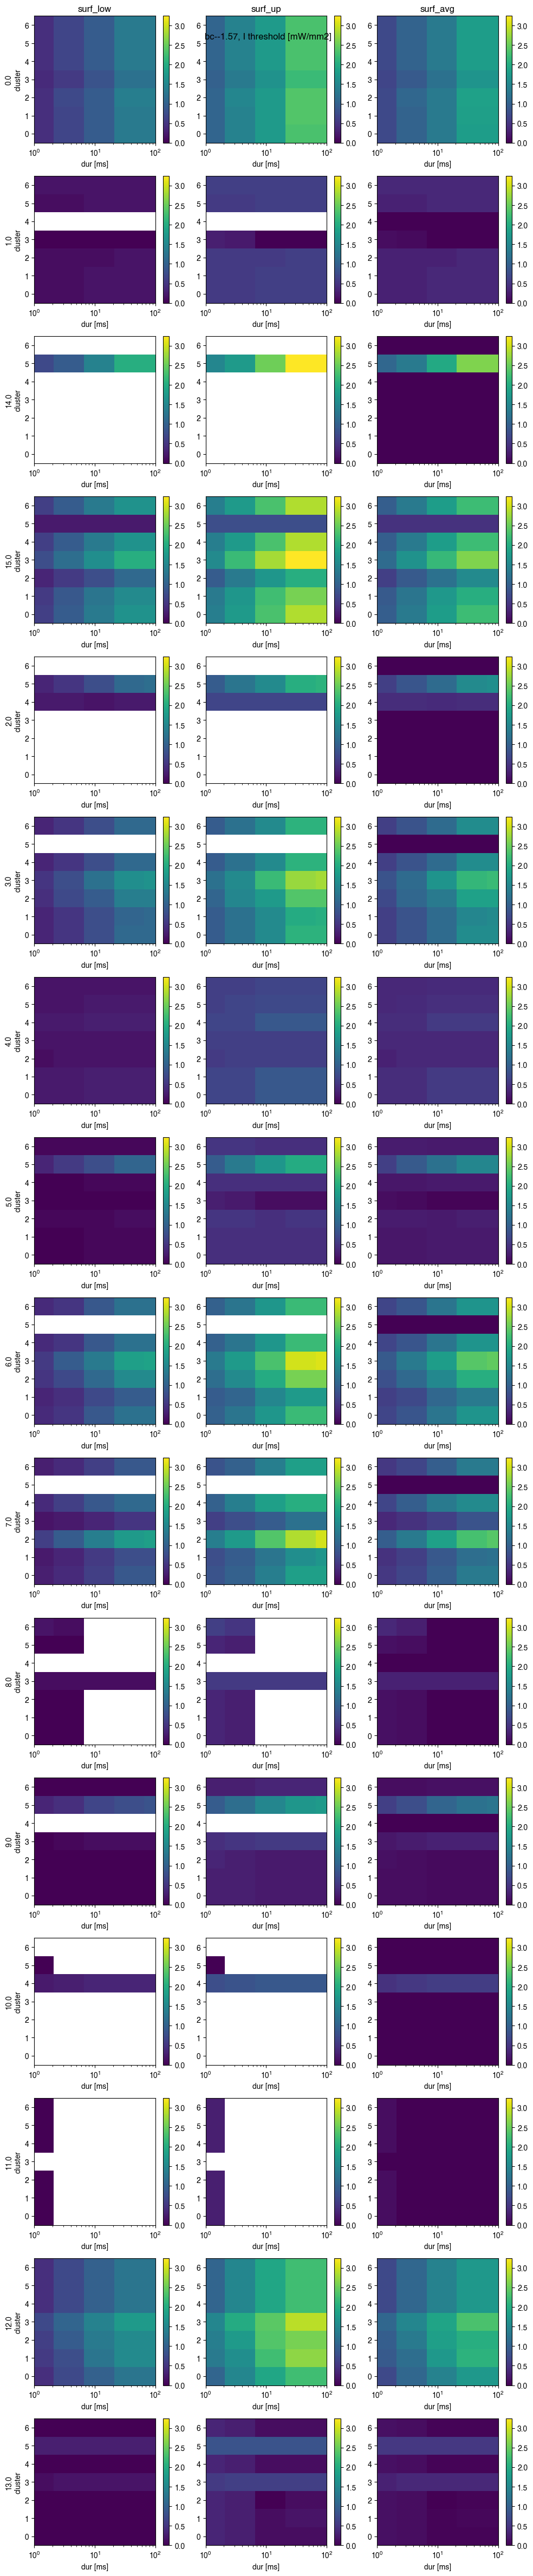

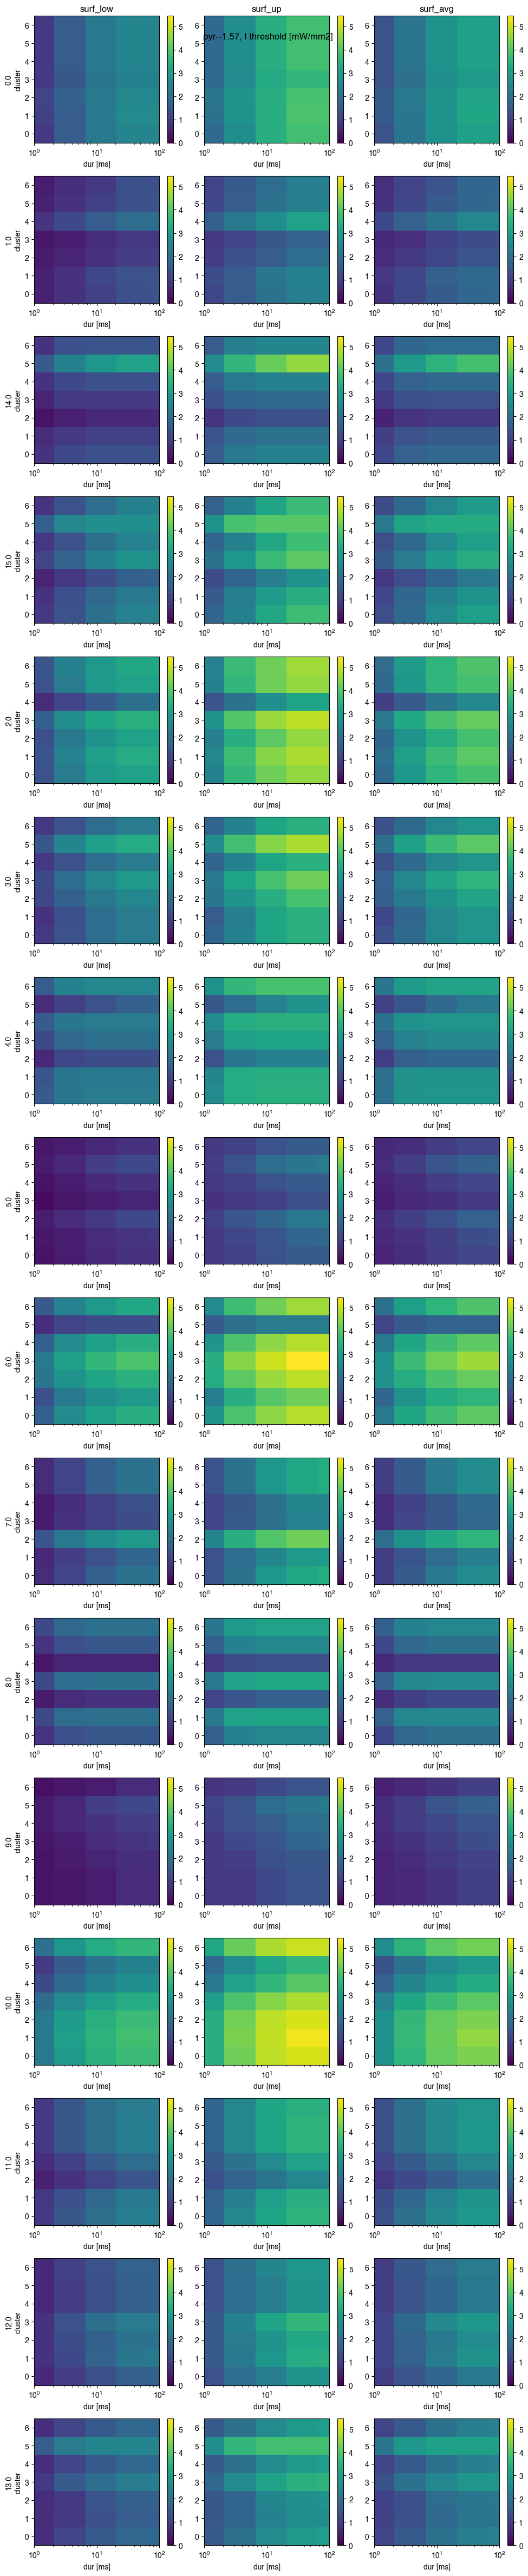

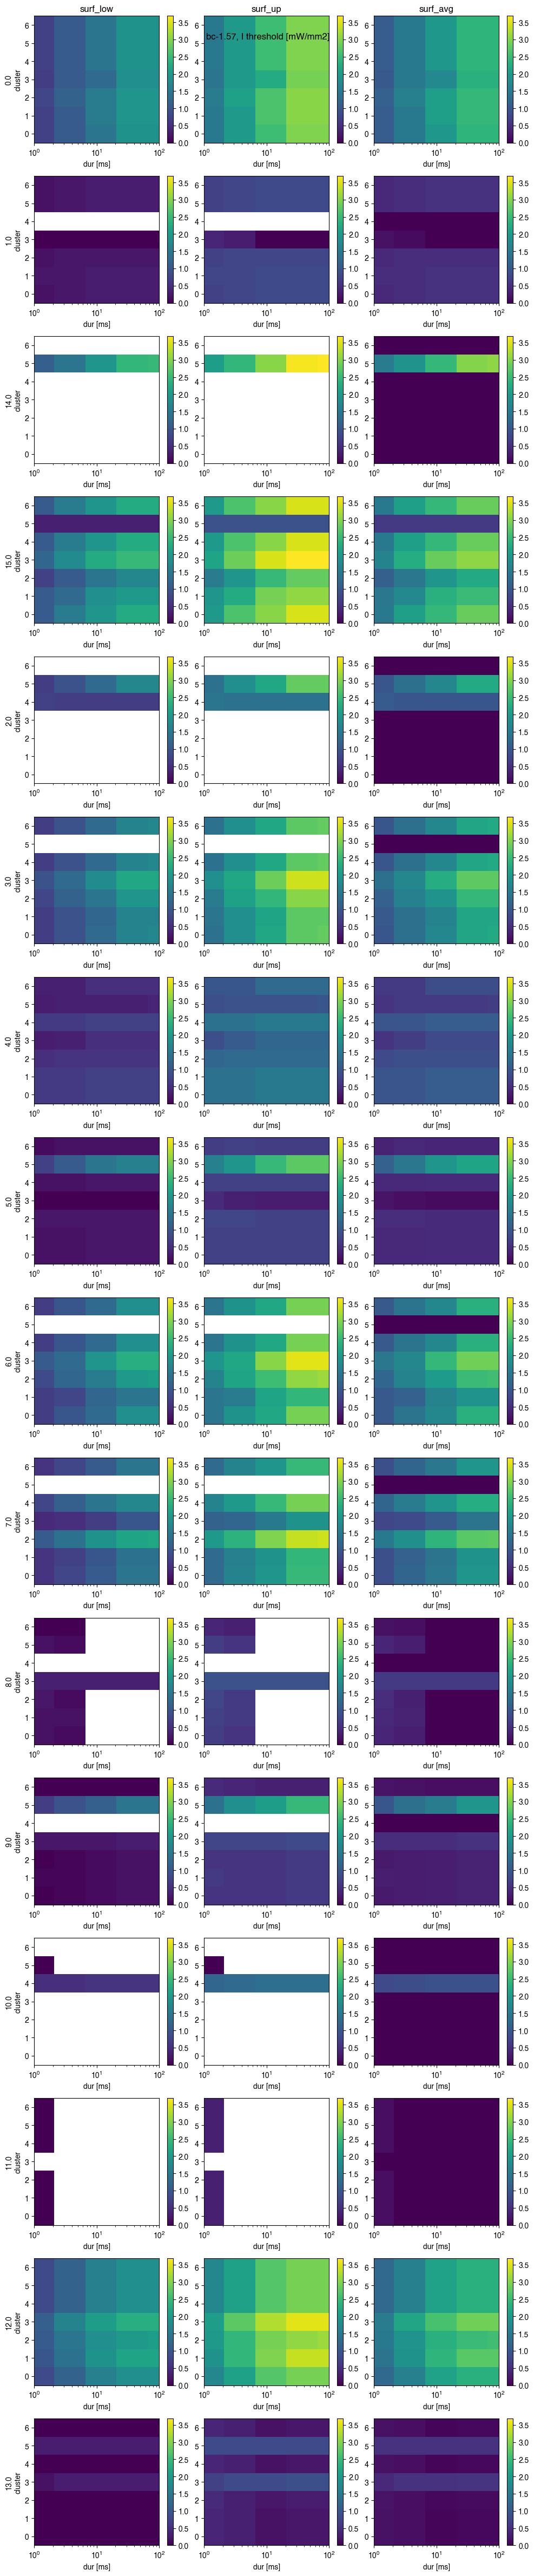

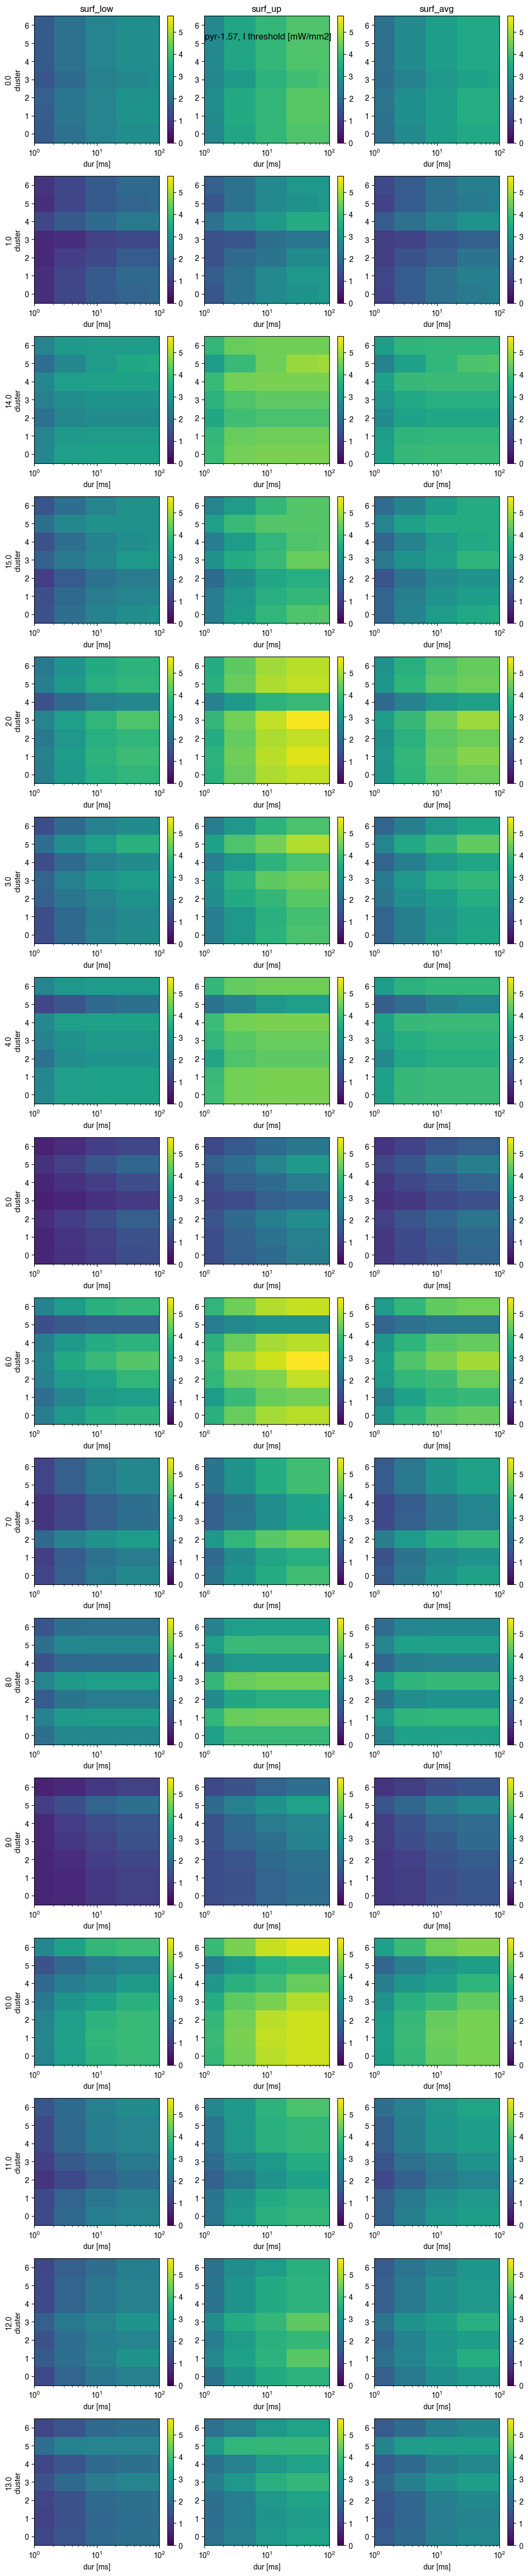

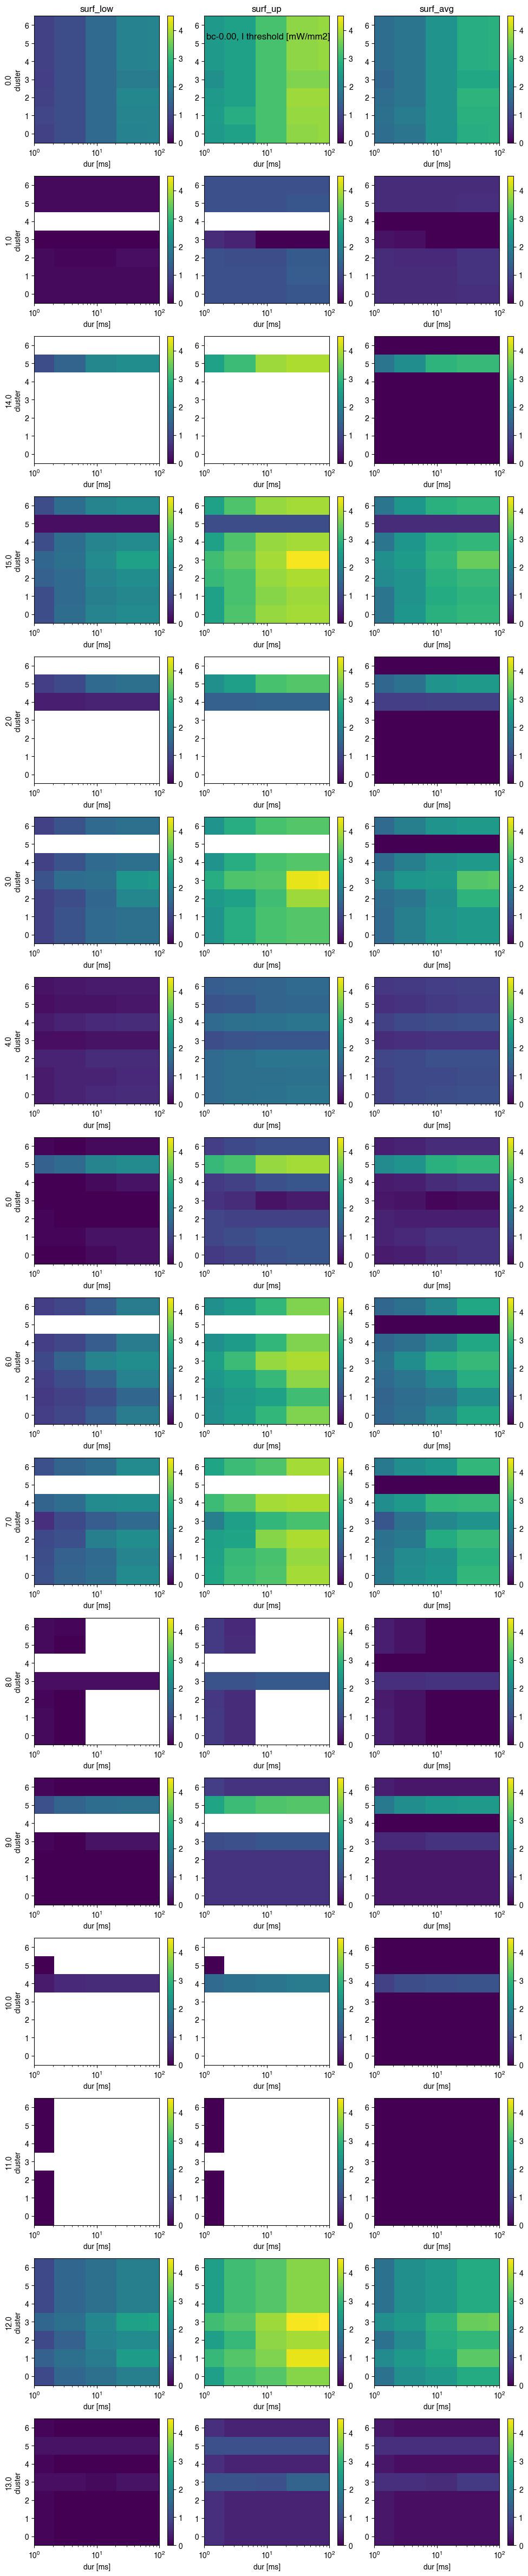

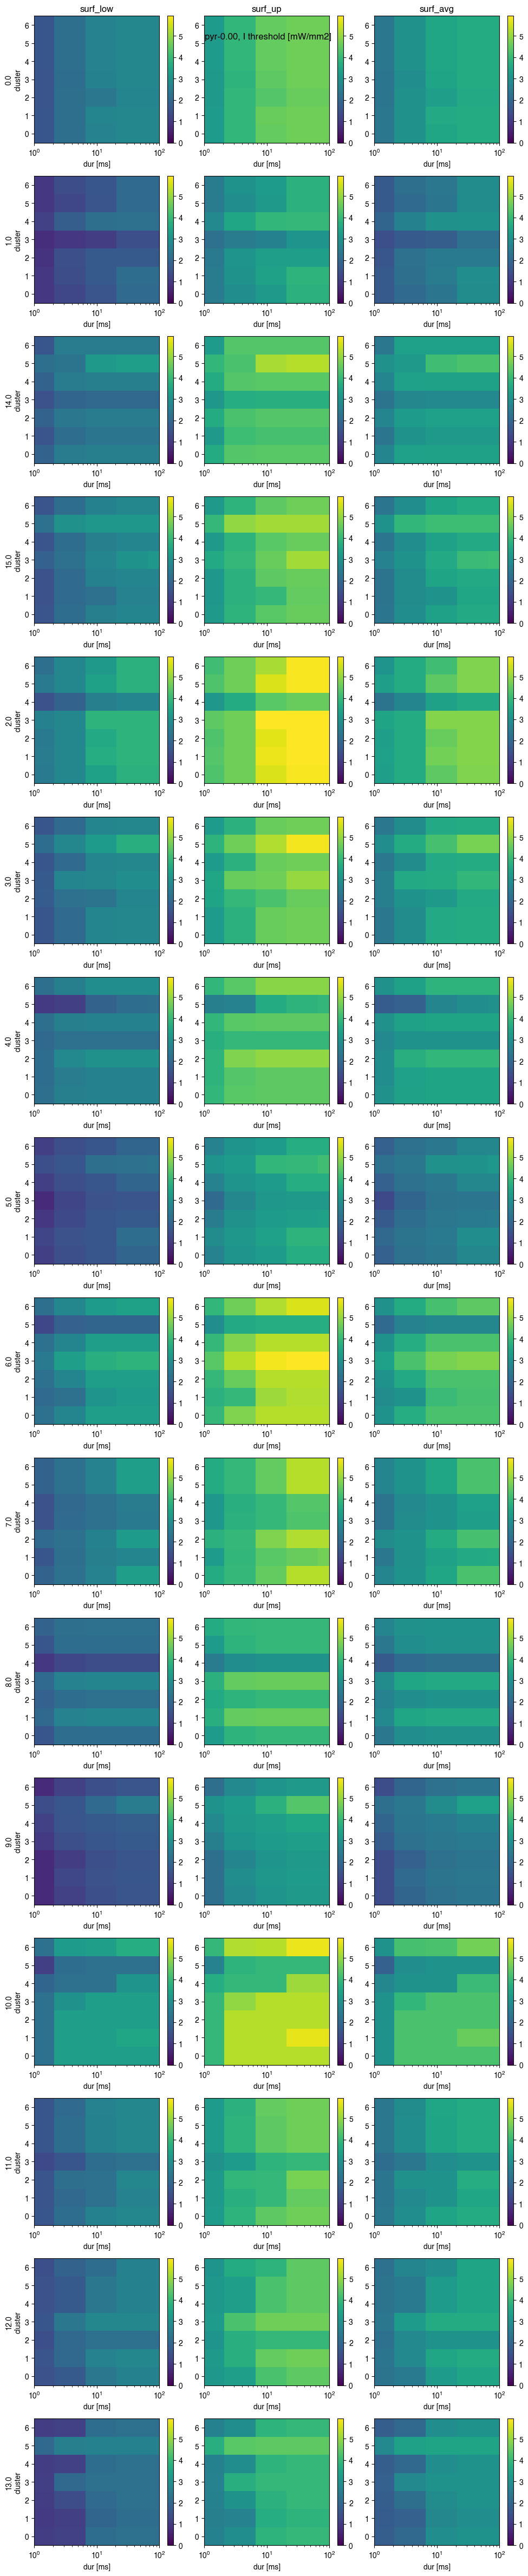

In [7]:
for pitch in unique_values_columns_vta['theta_0']:
    for cellt in unique_values_columns_vta['celltype']:
        fig_df = vta_df[selection_generator(vta_df,unique_values_columns=unique_values_columns_vta,celltype=cellt,level=100,theta_0=pitch)]
        uAxesVals = fig_df['cluster_eet'].unique()
        fig,axs = plt.subplots(16,3,tight_layout = True,figsize = (10,3*len(uAxesVals)))
        for i,datalabel in enumerate(['surf_low','surf_up','surf_avg']):
            if not all(np.isnan(fig_df[datalabel])):
                Imin = 0#np.nanmin(fig_df[datalabel])
                if 'surf' in datalabel:
                    Imax = np.nanmax(fig_df[['surf_up','surf_low']].values)
                    norm = mpl.cm.colors.Normalize(vmax=Imax, vmin=Imin)
                else:
                    Imax = np.nanmax(fig_df[datalabel])
                    norm = mpl.cm.colors.PowerNorm(gamma=2,vmax=Imax, vmin=Imin)

                for oL,ax in zip(uAxesVals,axs[:,i]):
                    intm_df = fig_df[fig_df['cluster_eet']==oL]
                    data_toplot = EcF.prepareDataforInterp(np.array((intm_df['dur'],intm_df['idx_incluster_eet'],intm_df[datalabel])).T,'ninterp',sorted=False)
                    yY, zZ = np.meshgrid(data_toplot[0],data_toplot[1],indexing='ij')

                    im,cb = EcF.slicePlot(data_toplot,ax,fig,plotGrid=(yY,zZ),structured=True, norm=norm)
                    ax.set_xscale('log')
                    ax.set_xlim((min(intm_df['dur'].unique()),max(intm_df['dur'].unique())))
                    ax.set_xlabel('dur [ms]')
                    if i==0:
                        ax.set_ylabel(f'{oL}\ncluster')
                    if oL == uAxesVals[0]:
                        ax.set_title(datalabel)
        fig.suptitle(f'{cellt}-{pitch:0.2f}, I threshold [mW/mm2]')
        print()

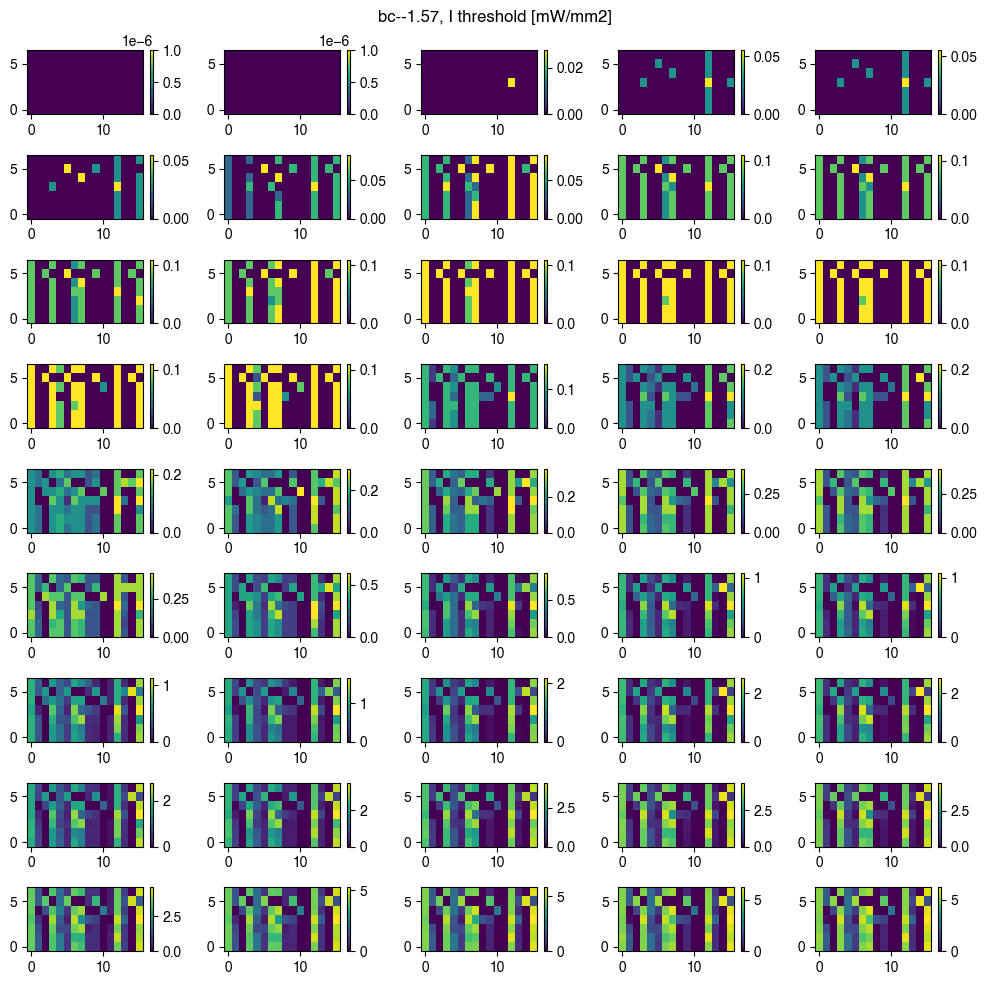

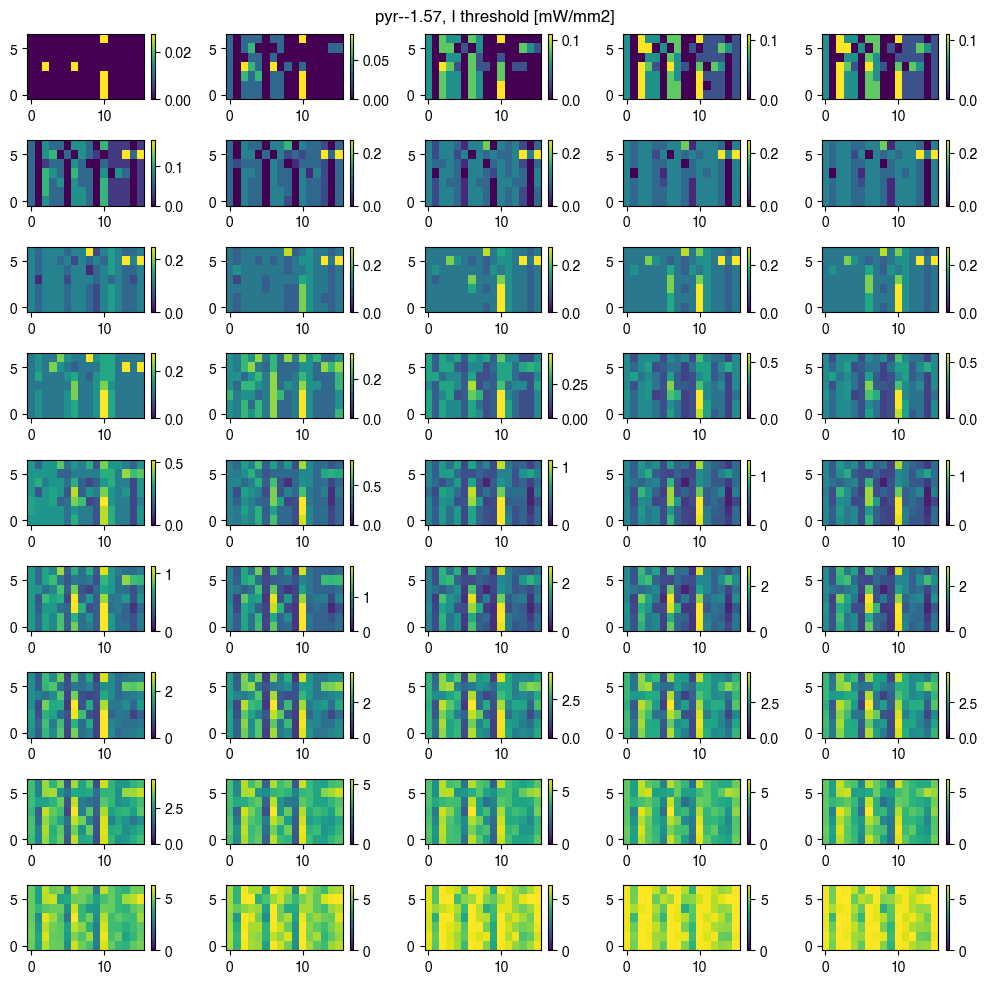

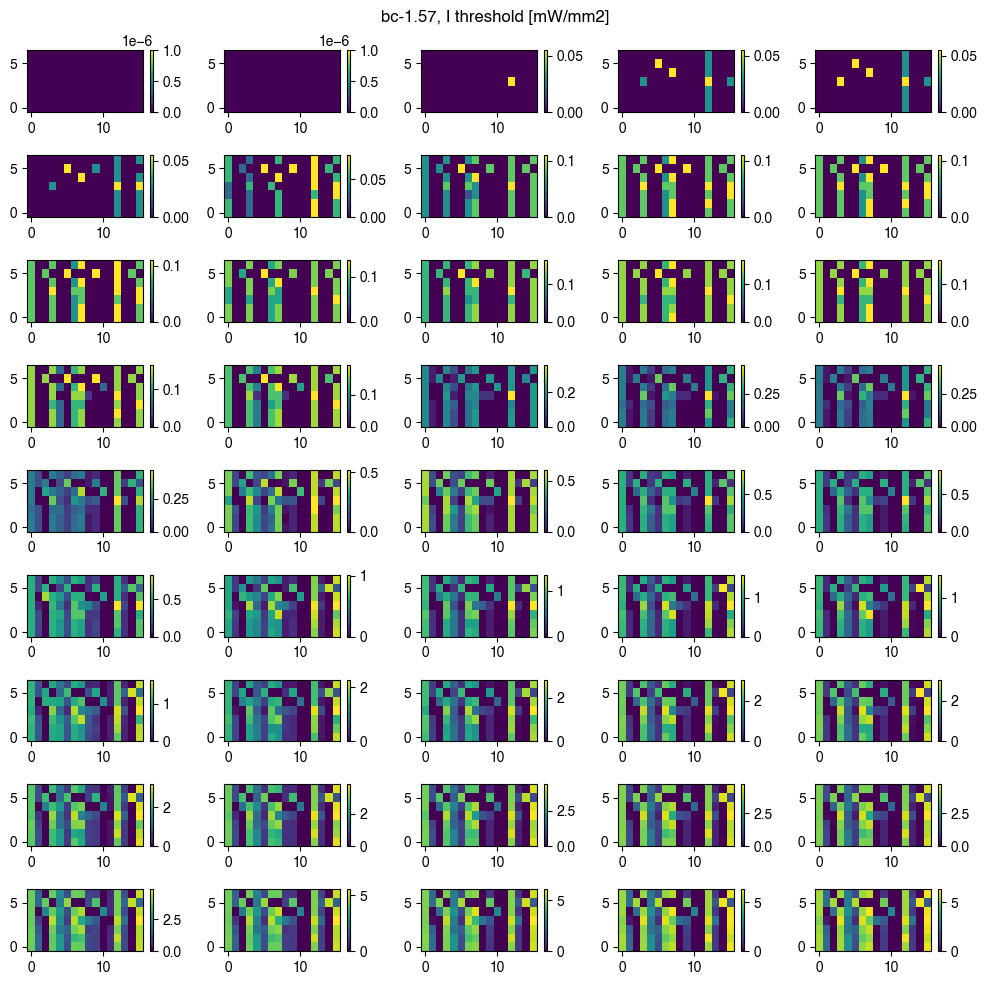

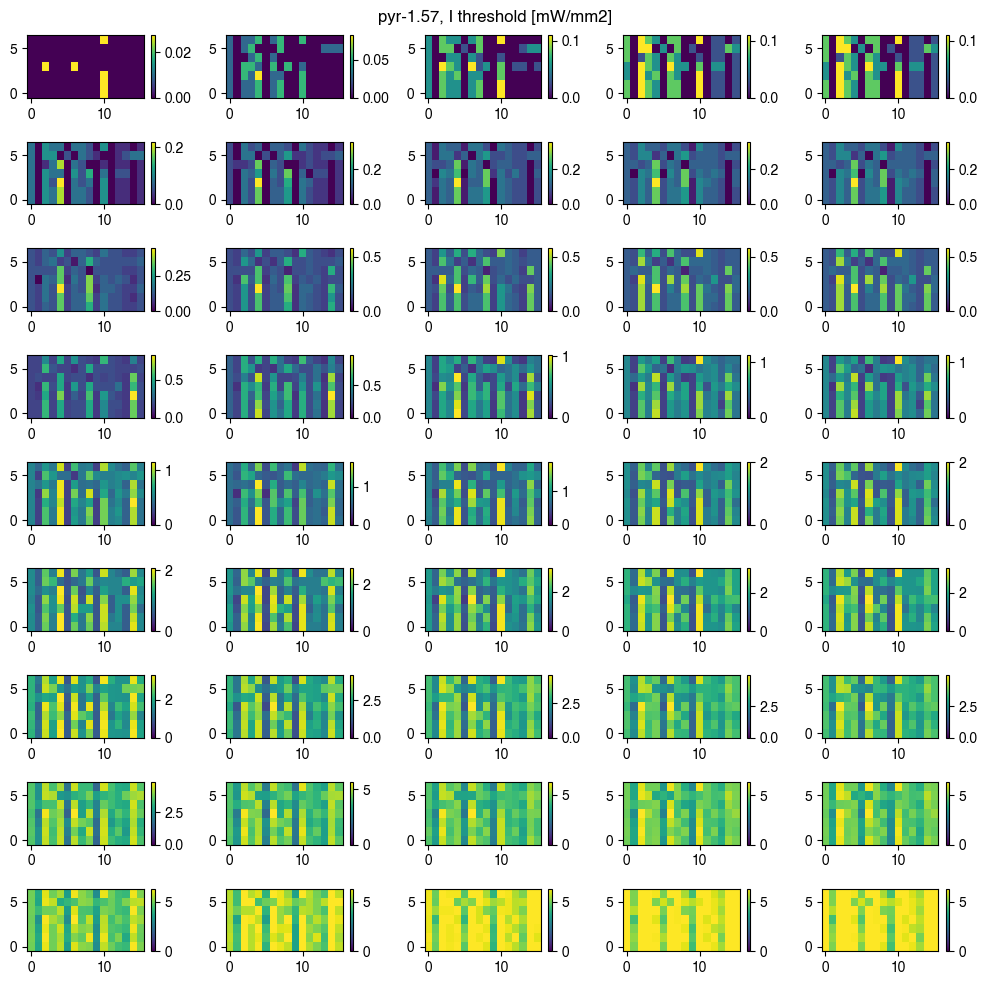

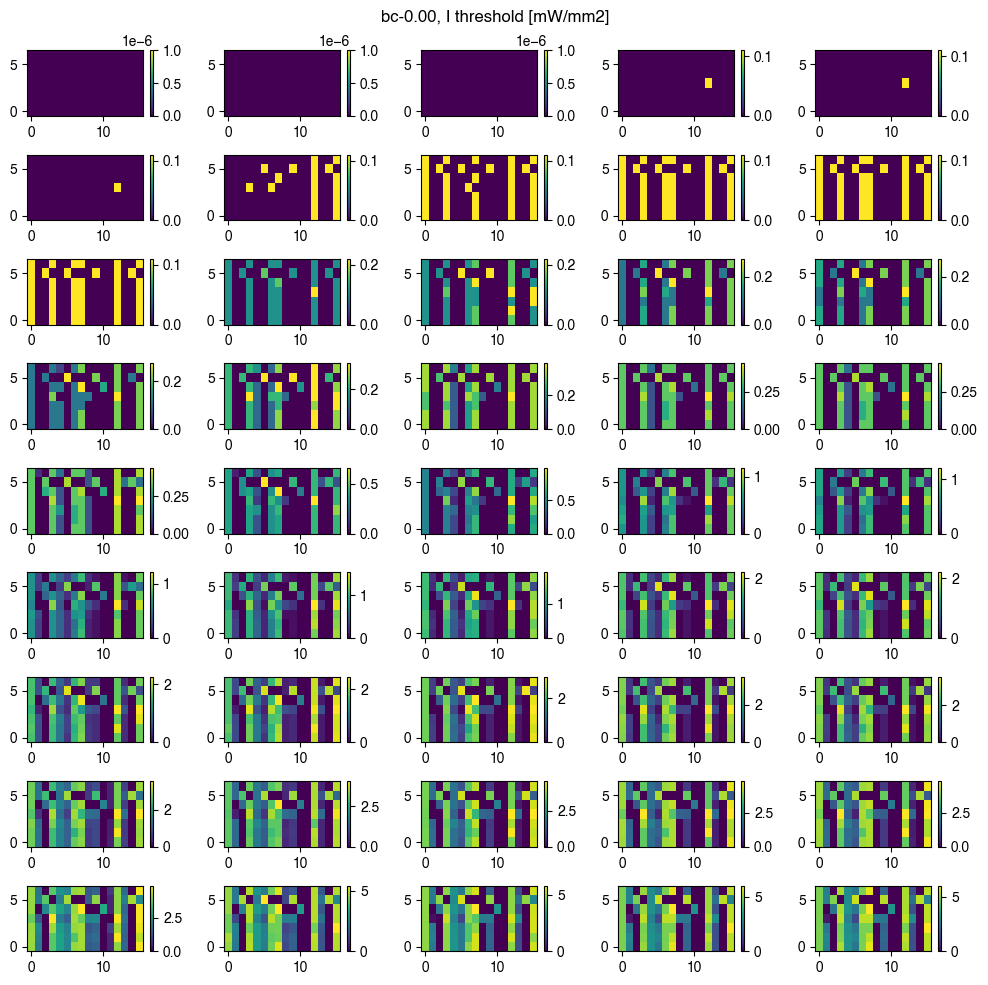

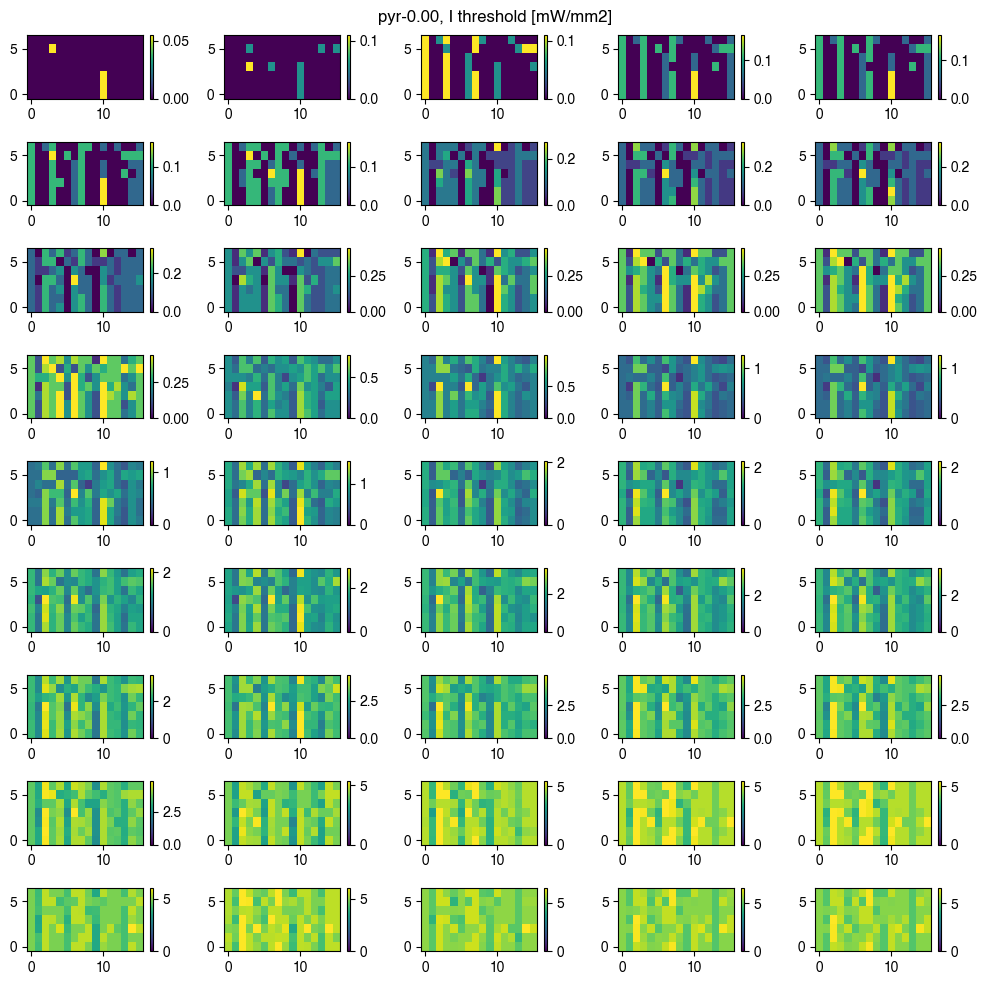

In [8]:
datalabel = 'surf_avg'
for pitch in unique_values_columns_vta['theta_0']:
    for cellt in unique_values_columns_vta['celltype']:
        fig_df = vta_df[selection_generator(vta_df,unique_values_columns=unique_values_columns_vta,celltype=cellt,theta_0=pitch)]
        urowAxesVals = fig_df['level'].unique()[:]
        ucolumnAxesVals = fig_df['dur'].unique()[:]
        fig,axs = plt.subplots(len(urowAxesVals),len(ucolumnAxesVals), tight_layout=True,figsize=(10,10))
        for i, row in enumerate(urowAxesVals):
            for j, column in enumerate(ucolumnAxesVals):
                ax_df = fig_df[selection_generator(fig_df,unique_values_columns=unique_values_columns_vta,level=row,dur=column)]
                if not all(np.isnan(ax_df[datalabel])):
                    Imin = 0 #np.nanmin(fig_df[datalabel])
                    if 'surf' in datalabel:
                        Imax = max((np.nanmax(ax_df[datalabel].values),Imin+1e-6))
                        norm = mpl.cm.colors.Normalize(vmax=Imax, vmin=Imin)

                    data_toplot = EcF.prepareDataforInterp(np.array((ax_df['cluster_eet'],ax_df['idx_incluster_eet'],ax_df[datalabel])).T,'ninterp',sorted=False)
                    yY, zZ = np.meshgrid(data_toplot[0],data_toplot[1],indexing='ij')

                    im,cb = EcF.slicePlot(data_toplot,axs[i,j],fig,plotGrid=(yY,zZ),structured=True, norm=norm)
                    ax.set_xlabel('cluster_eet')
                    ax.set_ylabel('idx_incluster_eet')

        fig.suptitle(f'{cellt}-{pitch:0.2f}, I threshold [mW/mm2]')
        print()

C:\Users\rschoete\AppData\Local\Temp\ipykernel_24236\1475314153.py:17: RuntimeWarning: invalid value encountered in true_divide
  data_toplot[-1]=data_toplot[-1]/data_toplot[-1][:,0:1]*100
C:\Users\rschoete\AppData\Local\Temp\ipykernel_24236\1475314153.py:19: RuntimeWarning: All-NaN slice encountered
  Imin = np.nanmax((np.nanmin(data_toplot[-1].ravel()),1e-2))
C:\Users\rschoete\AppData\Local\Temp\ipykernel_24236\1475314153.py:21: RuntimeWarning: All-NaN slice encountered
  Imax = np.nanmax((np.nanmax(data_toplot[-1].ravel()),Imin+1e-2))
C:\Users\rschoete\AppData\Local\Temp\ipykernel_24236\1475314153.py:17: RuntimeWarning: divide by zero encountered in true_divide
  data_toplot[-1]=data_toplot[-1]/data_toplot[-1][:,0:1]*100


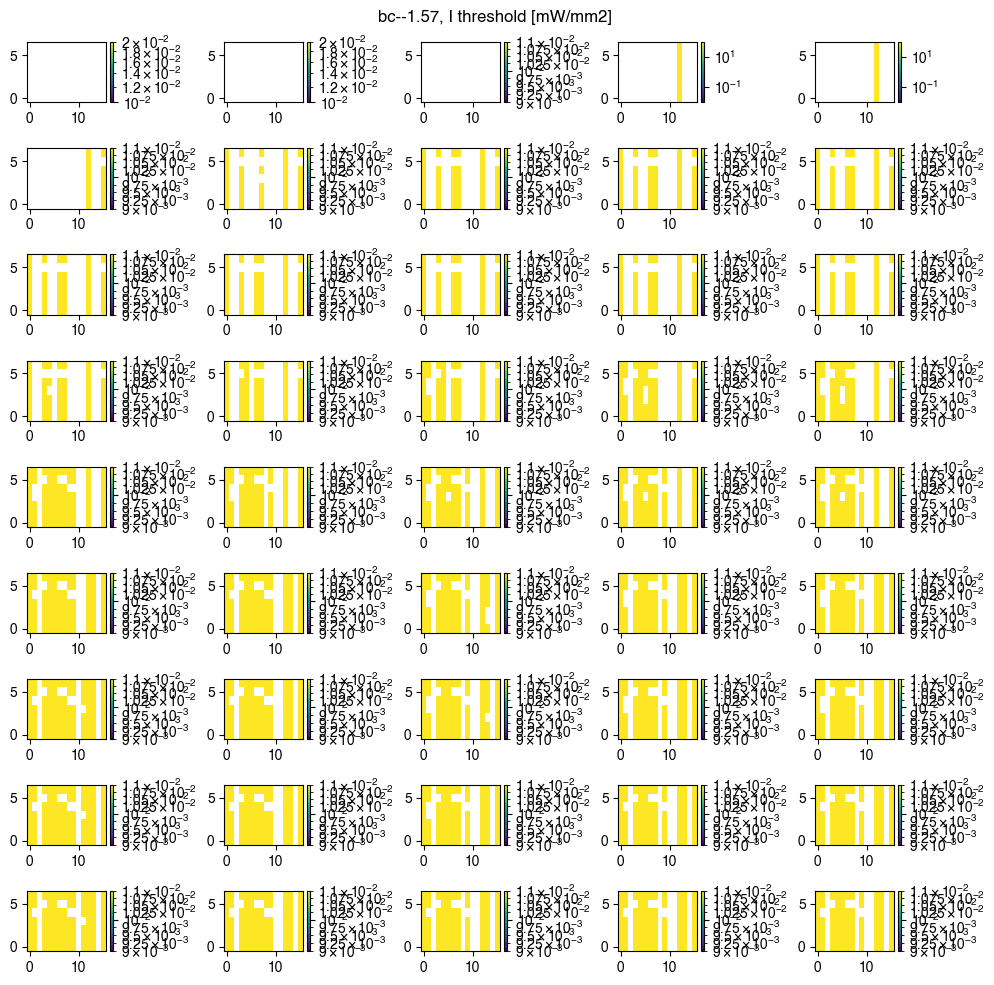

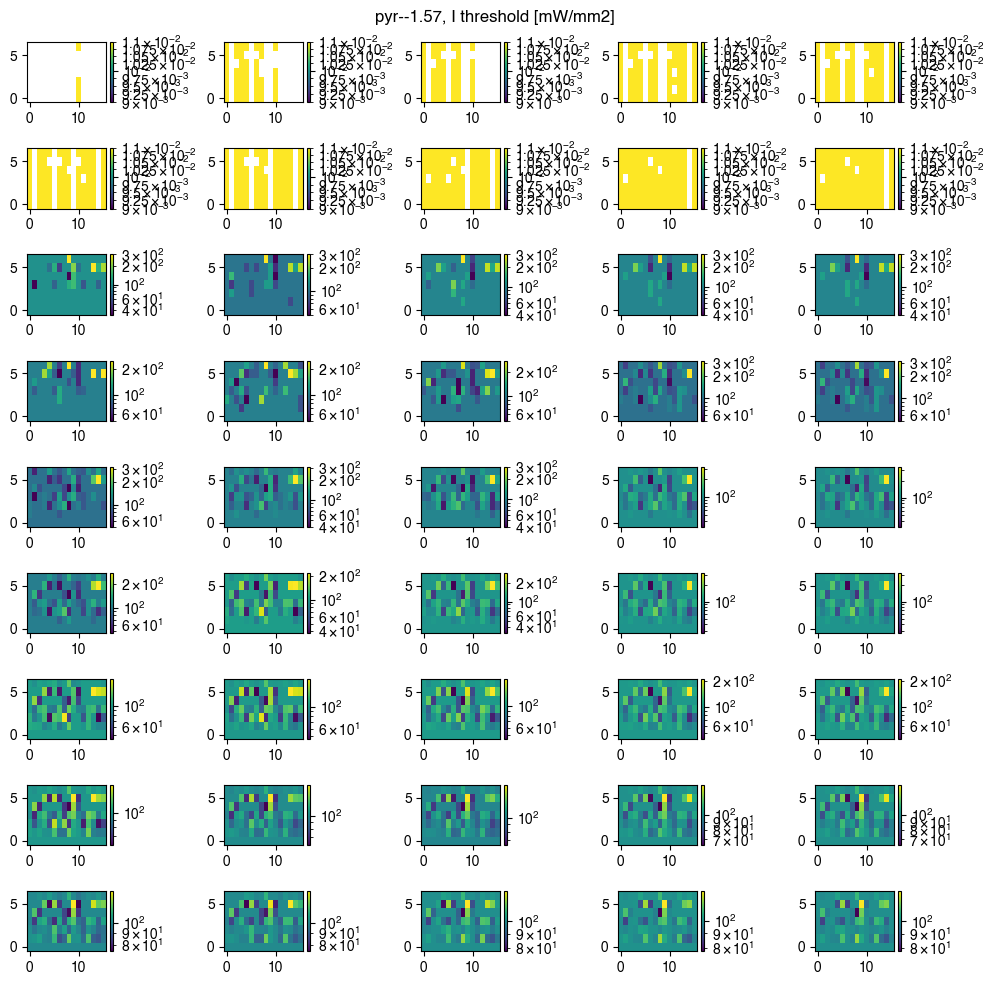

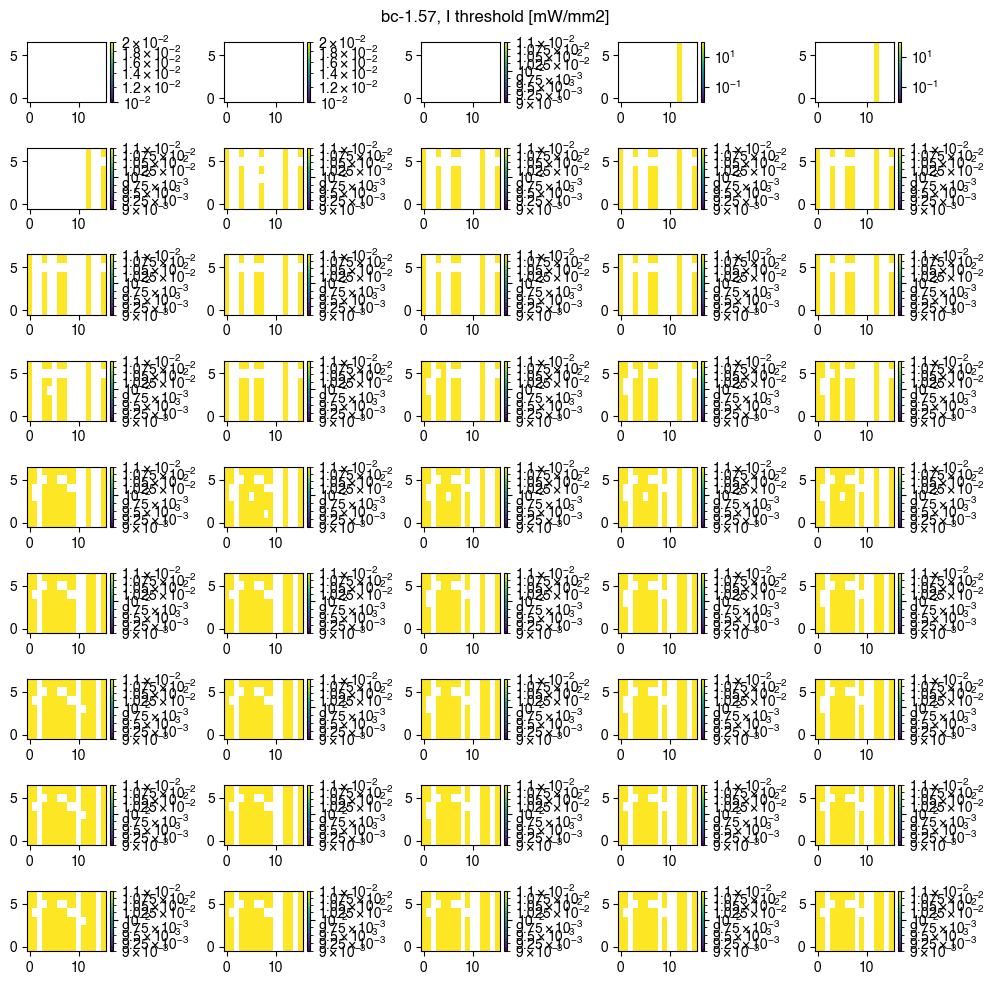

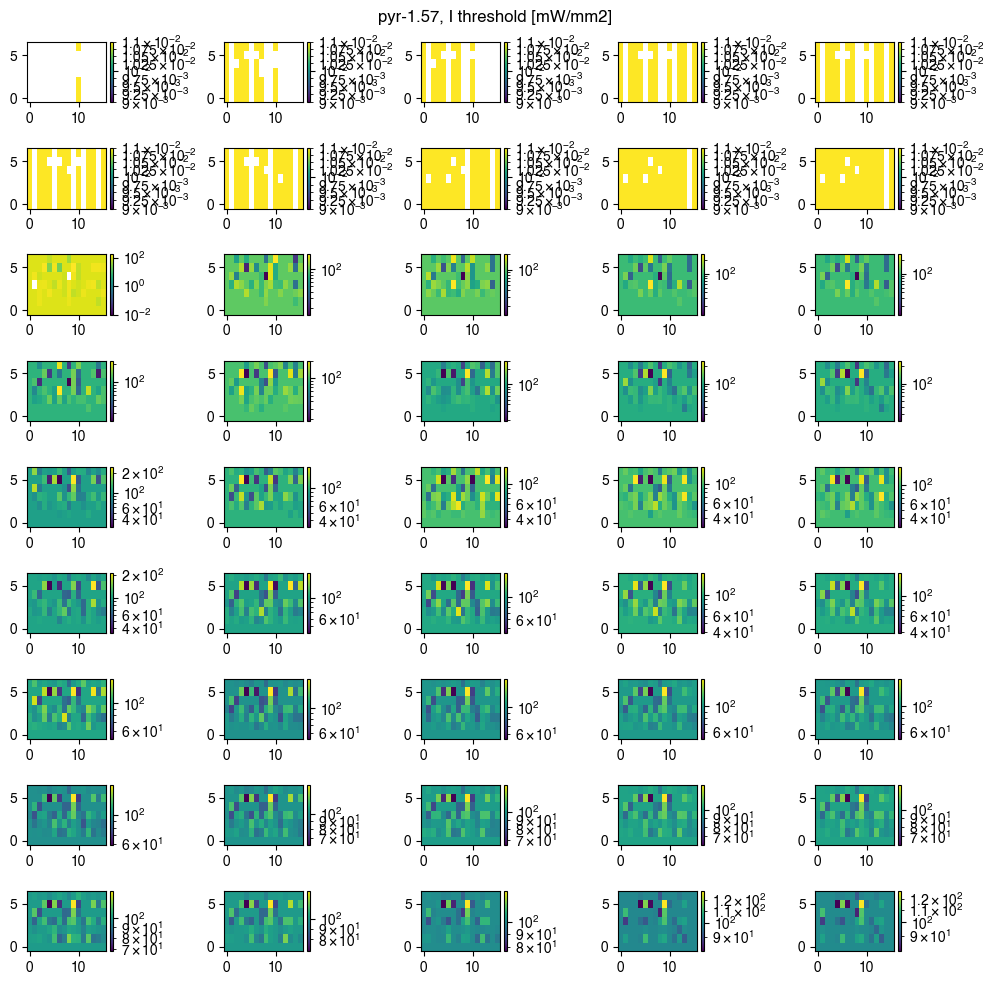

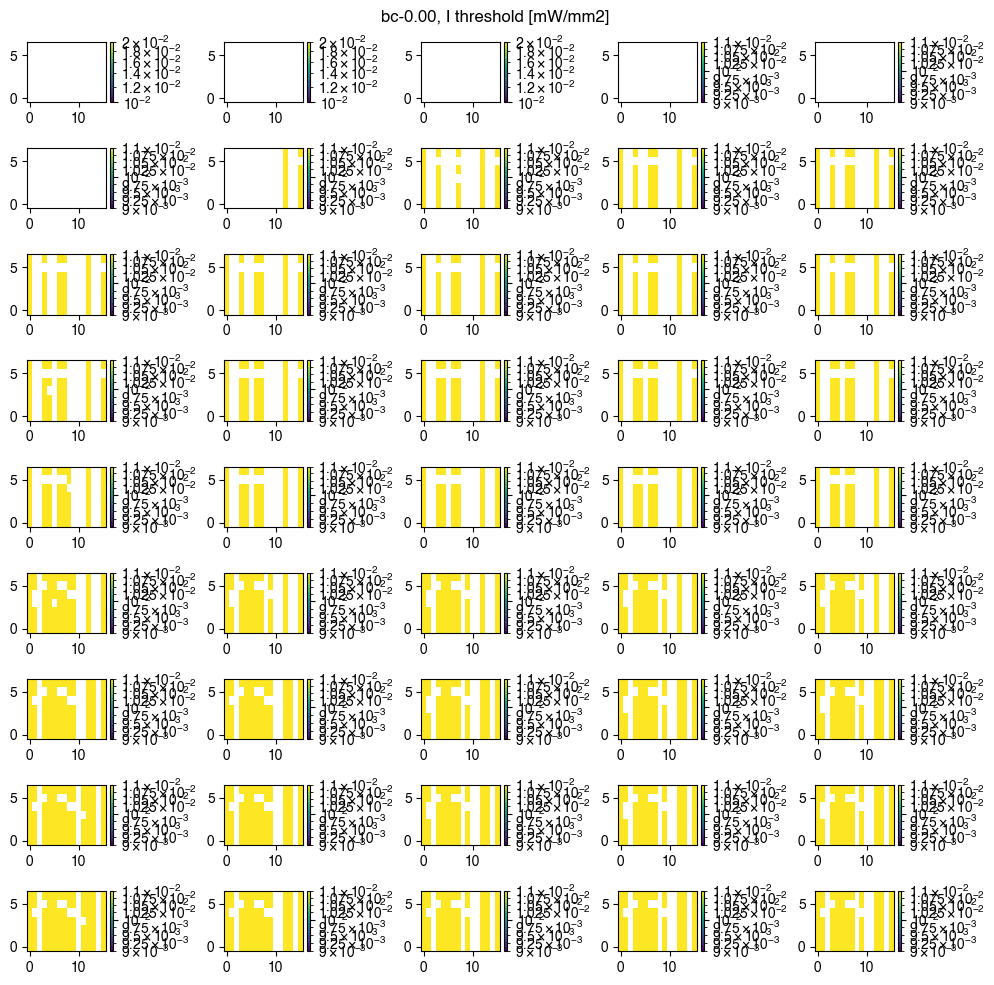

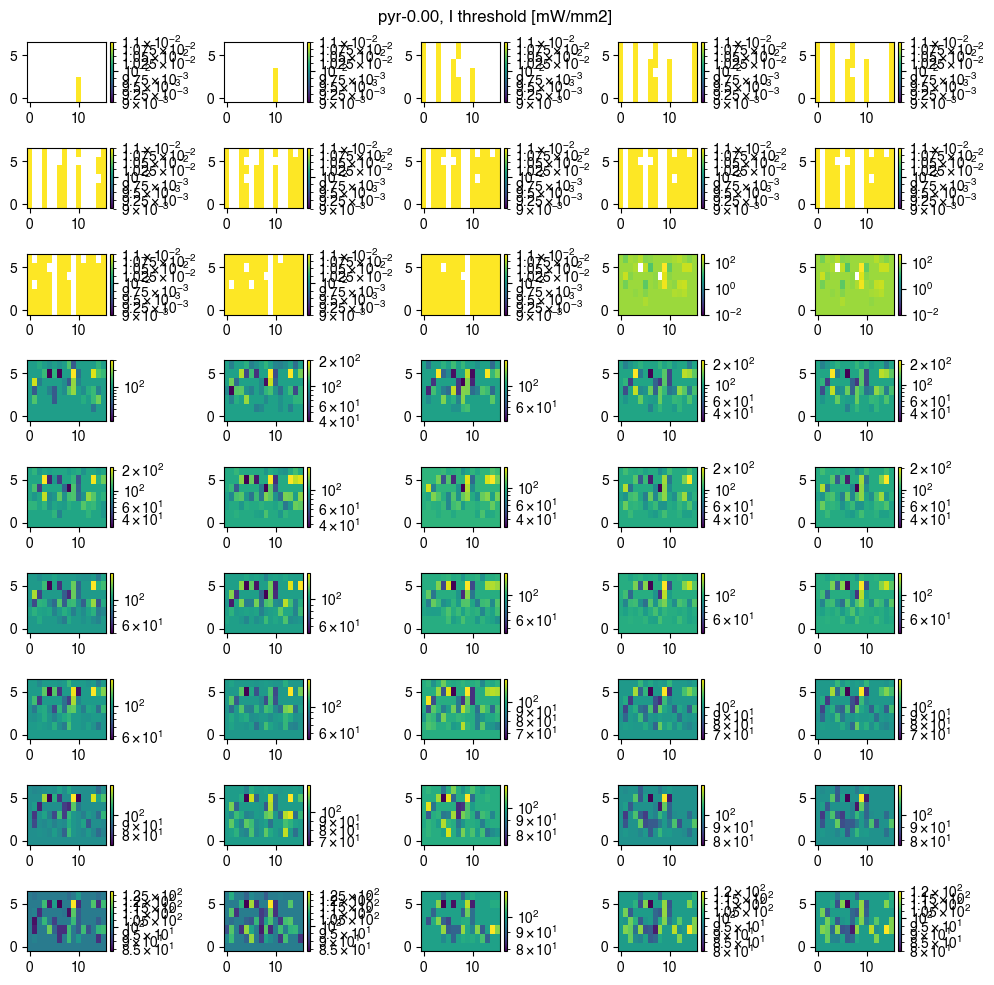

In [9]:
datalabel = 'surf_avg'
for pitch in unique_values_columns_vta['theta_0']:
    for cellt in unique_values_columns_vta['celltype']:
        fig_df = vta_df[selection_generator(vta_df,unique_values_columns=unique_values_columns_vta,celltype=cellt,theta_0=pitch)]
        urowAxesVals = fig_df['level'].unique()[:]
        ucolumnAxesVals = fig_df['dur'].unique()[:]
        fig,axs = plt.subplots(len(urowAxesVals),len(ucolumnAxesVals), tight_layout=True,figsize=(10,10))
        for i, row in enumerate(urowAxesVals):
            for j, column in enumerate(ucolumnAxesVals):
                ax_df = fig_df[selection_generator(fig_df,unique_values_columns=unique_values_columns_vta,level=row,dur=column)]
                if not all(np.isnan(ax_df[datalabel])):


                    data_toplot = EcF.prepareDataforInterp(np.array((ax_df['cluster_eet'],ax_df['idx_incluster_eet'],ax_df[datalabel])).T,'ninterp',sorted=False)
                    yY, zZ = np.meshgrid(data_toplot[0],data_toplot[1],indexing='ij')
                    data_toplot = list(data_toplot)
                    data_toplot[-1]=data_toplot[-1]/data_toplot[-1][:,0:1]*100

                    Imin = np.nanmax((np.nanmin(data_toplot[-1].ravel()),1e-2))
                    Imin = 1e-2 if np.isinf(Imin) else Imin
                    Imax = np.nanmax((np.nanmax(data_toplot[-1].ravel()),Imin+1e-2))
                    Imax = 1e-2 if np.isinf(Imax) else Imax
                    norm = mpl.cm.colors.LogNorm(vmax=Imax, vmin=Imin)
                    im,cb = EcF.slicePlot(data_toplot,axs[i,j],fig,plotGrid=(yY,zZ),structured=True, norm=norm)

        fig.suptitle(f'{cellt}-{pitch:0.2f}, I threshold [mW/mm2]')
        print()

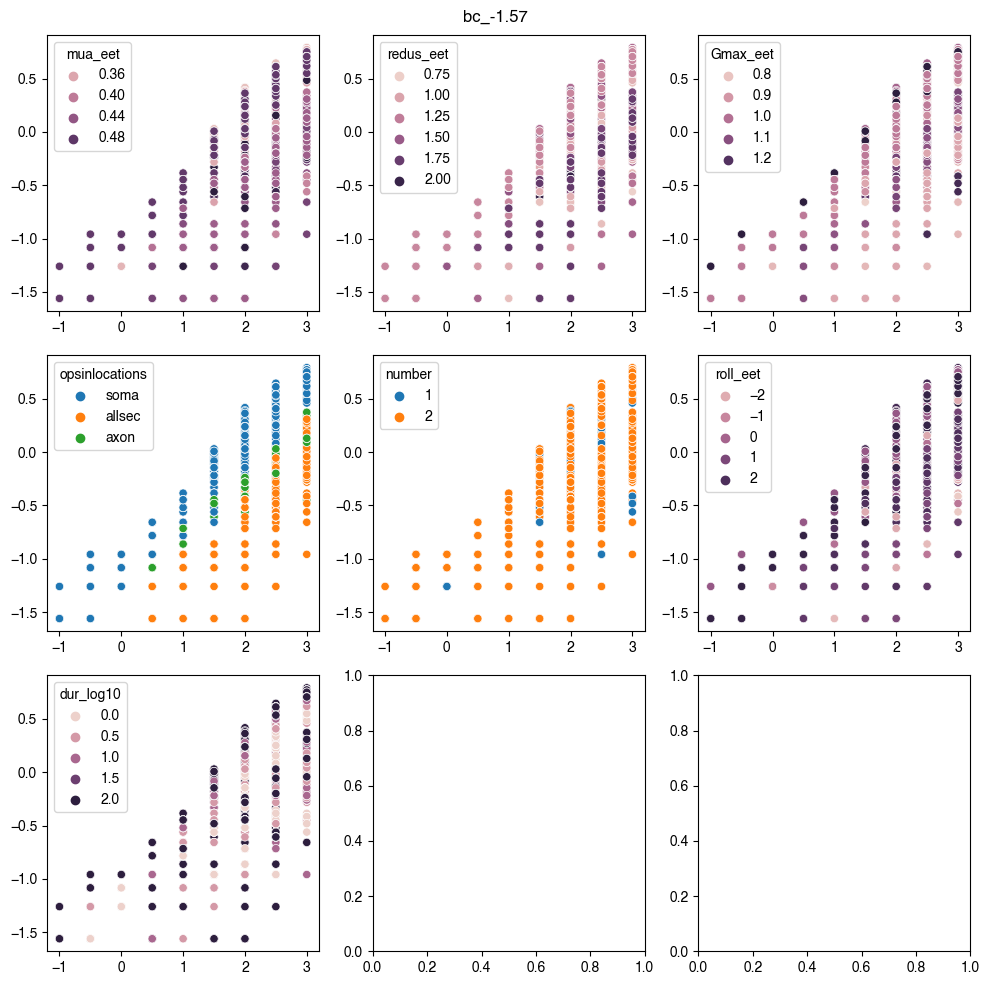

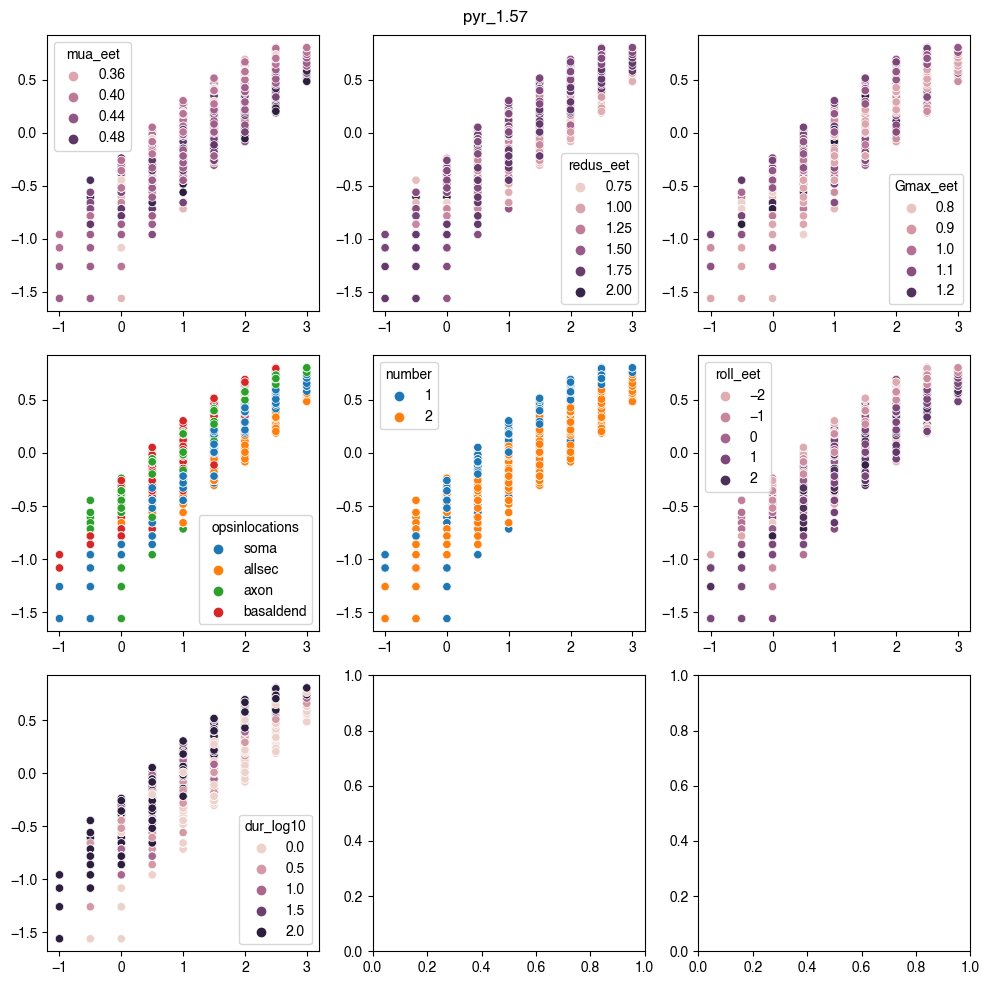

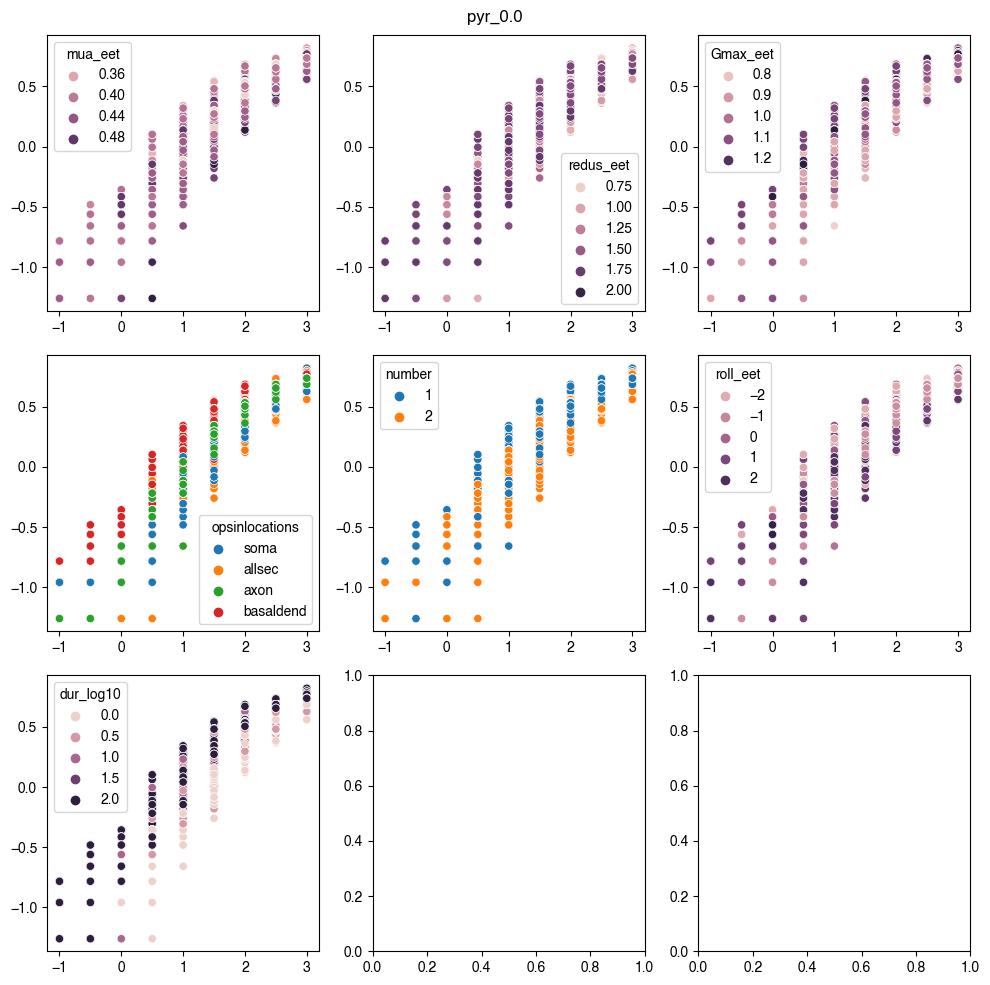

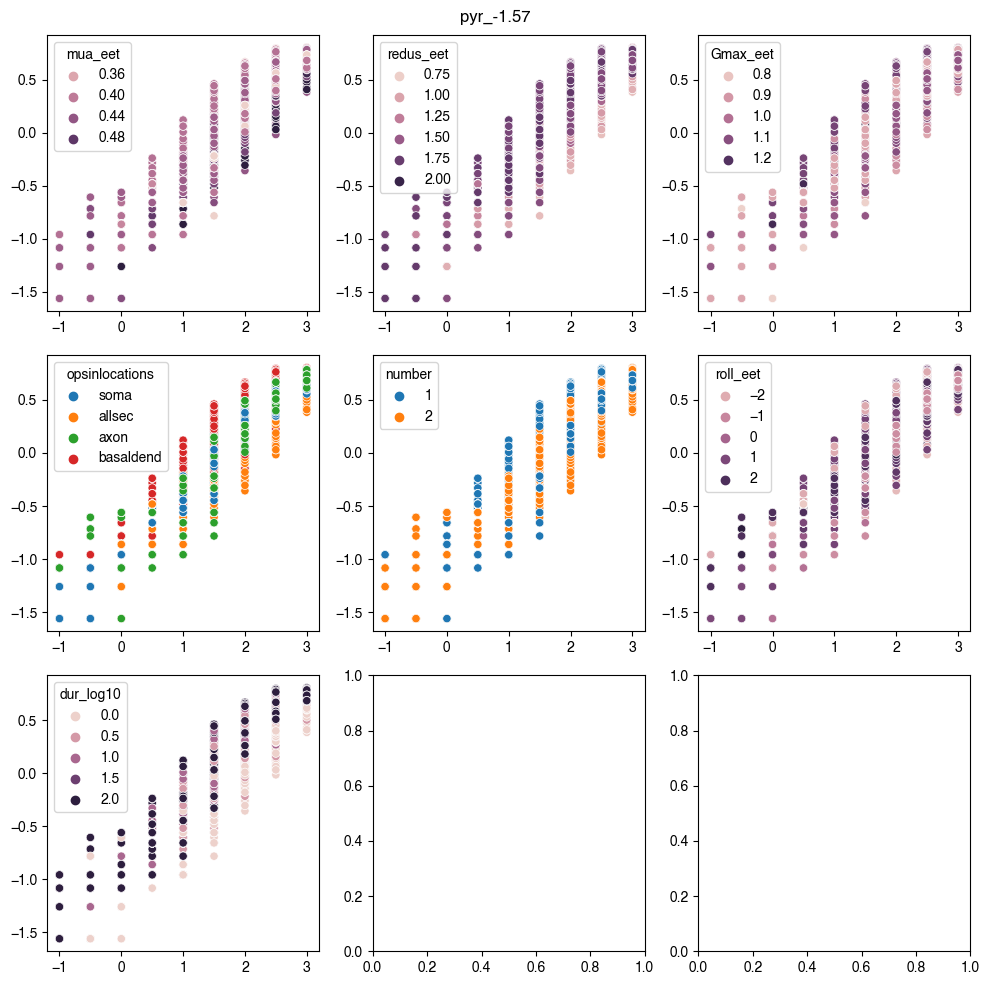

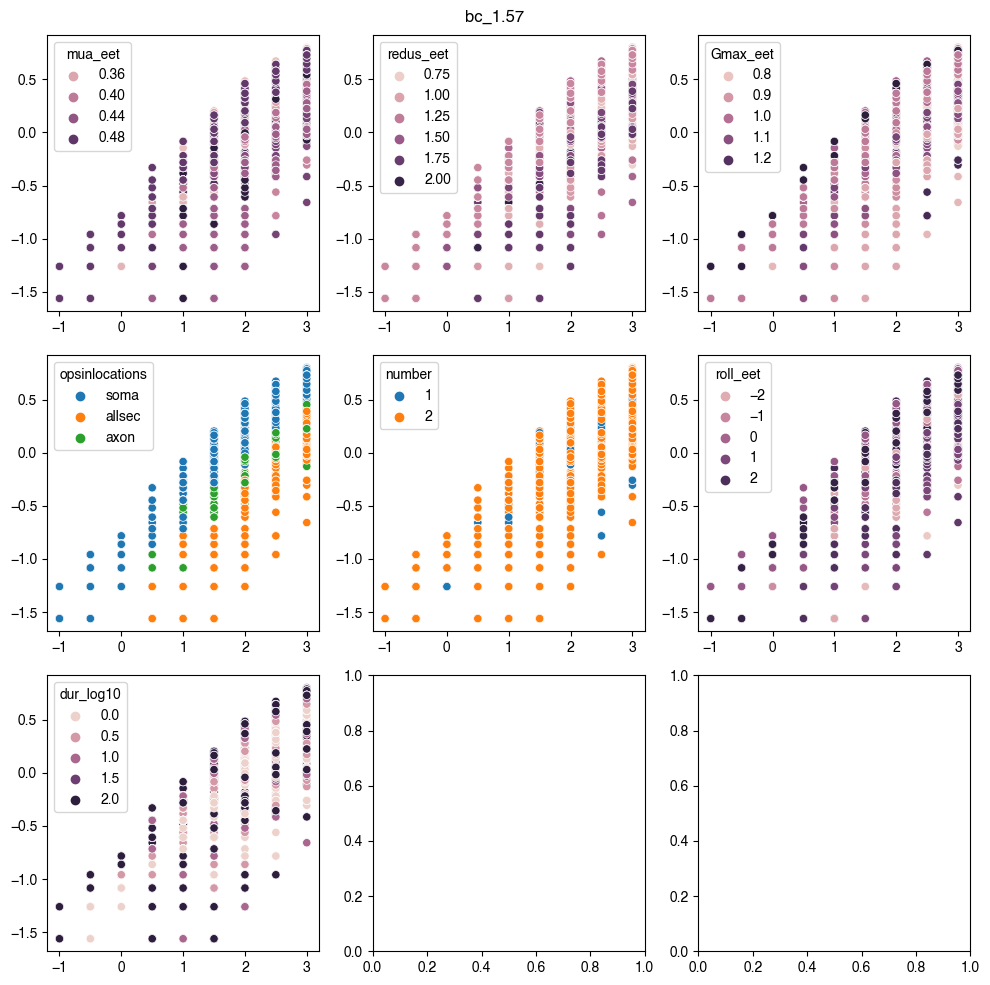

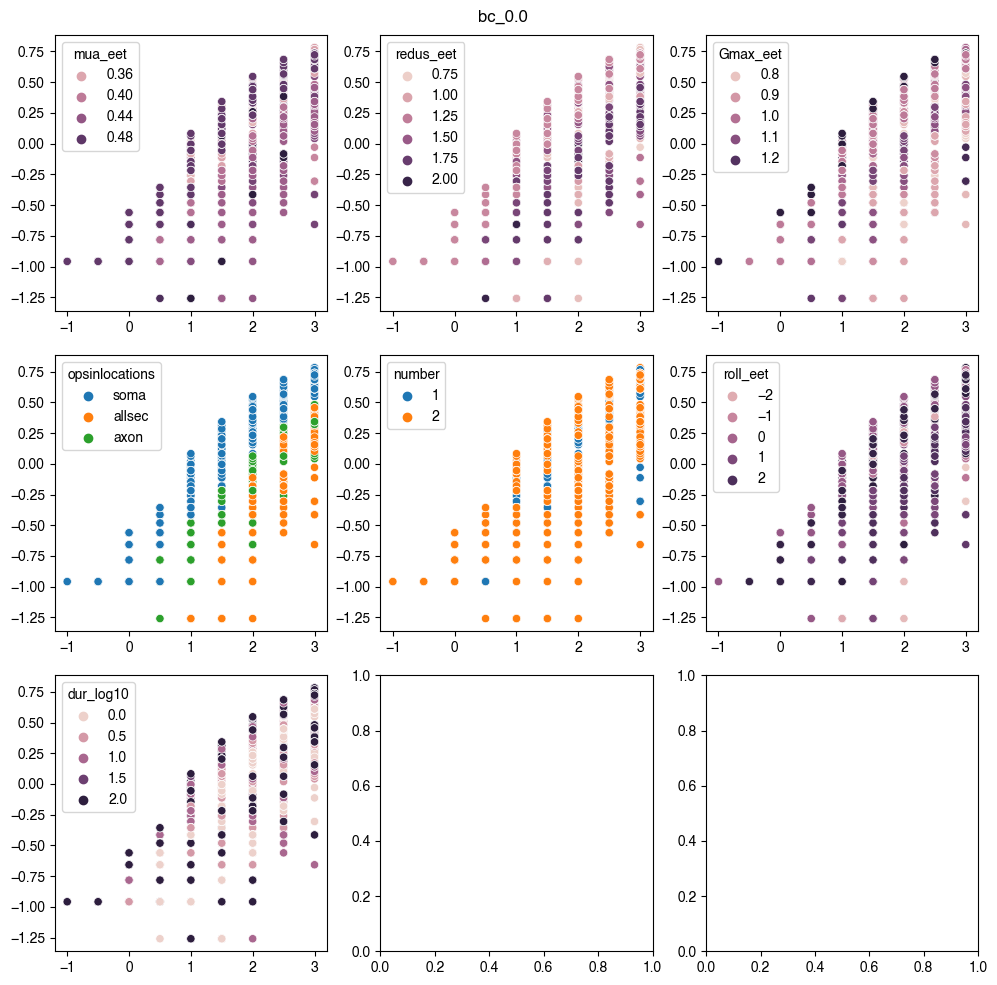

In [10]:
uct_theta = vta_limit_df['ct_theta'].unique()
row_strs = ['mua_eet', 'redus_eet', 'Gmax_eet', 'opsinlocations', 'number' ,'roll_eet', 'dur_log10']
for cth in uct_theta:
    fig,axs = plt.subplots(np.ceil(len(row_strs)/3).astype(int),3, tight_layout=True, figsize=(10,10))
    for r, ax in zip(row_strs,axs.ravel()):
        idx = (vta_df['ct_theta']==cth)
        sns.scatterplot(data=vta_df[idx],x='level_log10',y='surf_avg_log10', hue=r, ax=ax)

        ax.set_xlabel(None)
        ax.set_ylabel(None)
    fig.suptitle(cth)




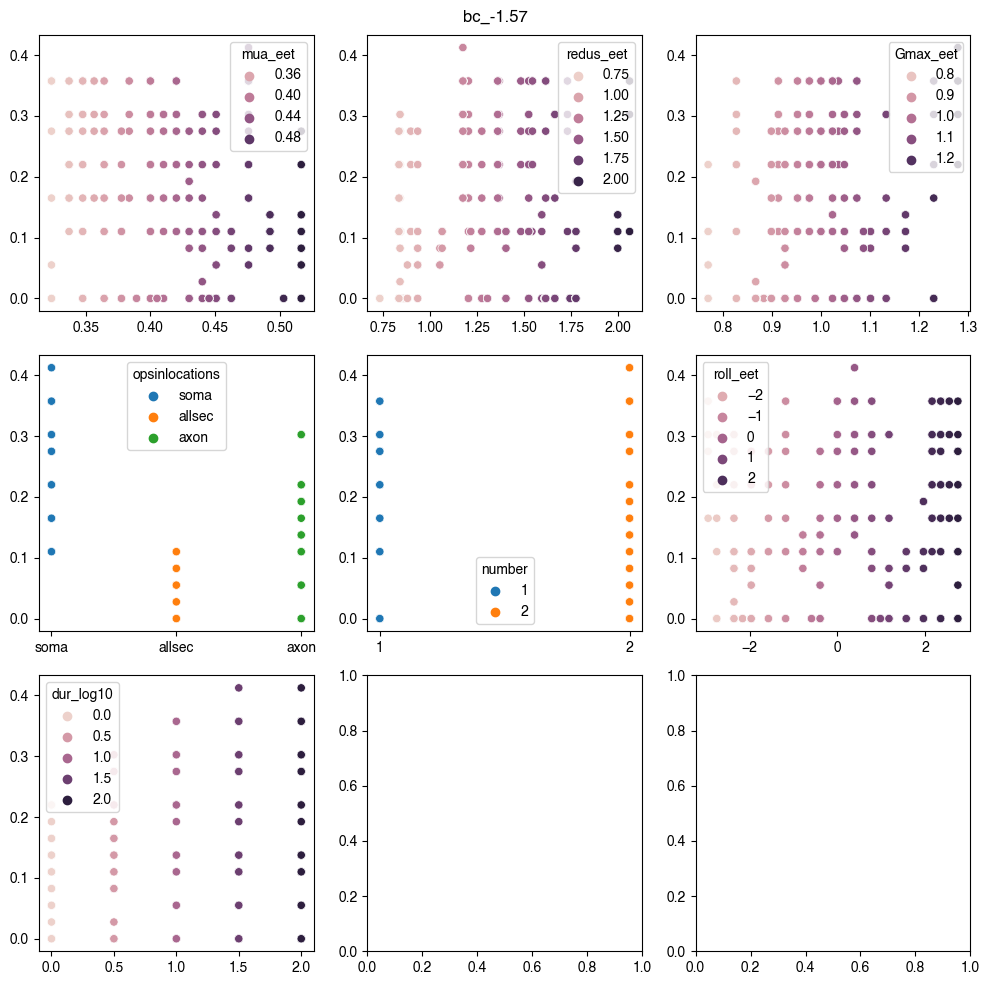

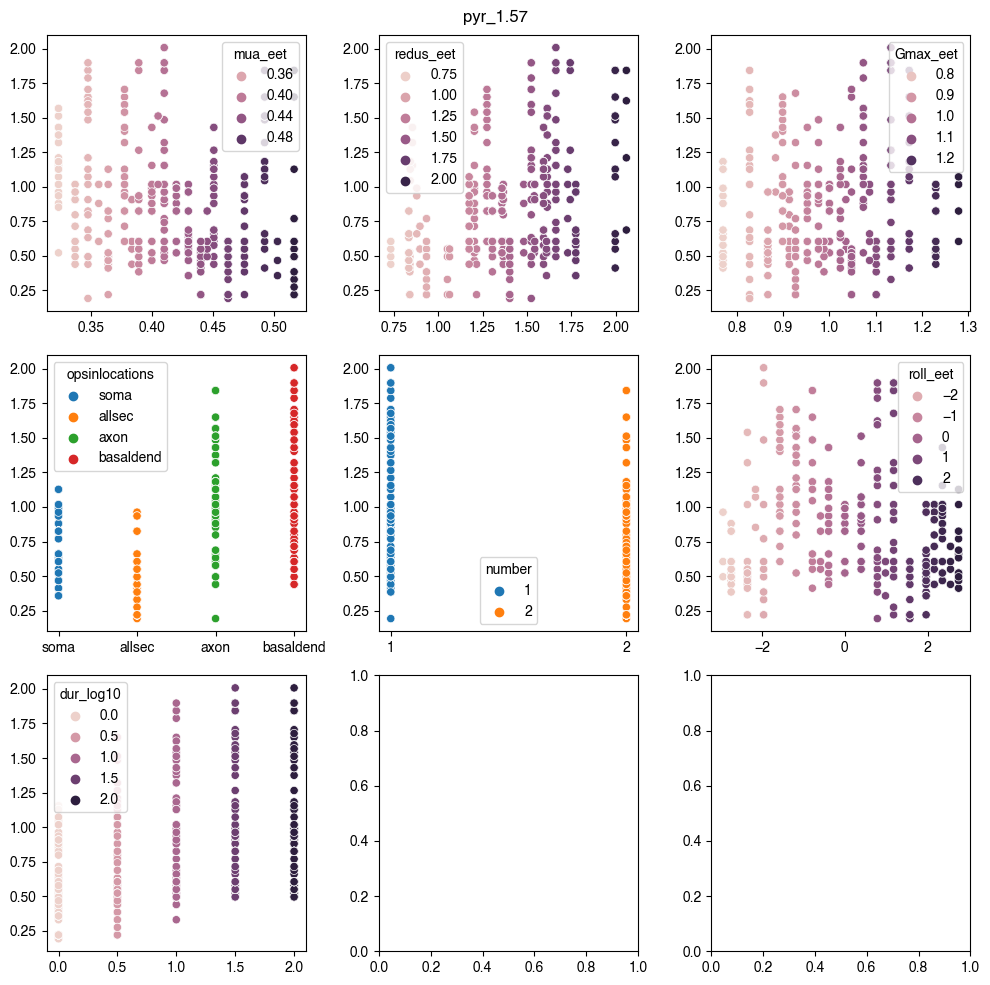

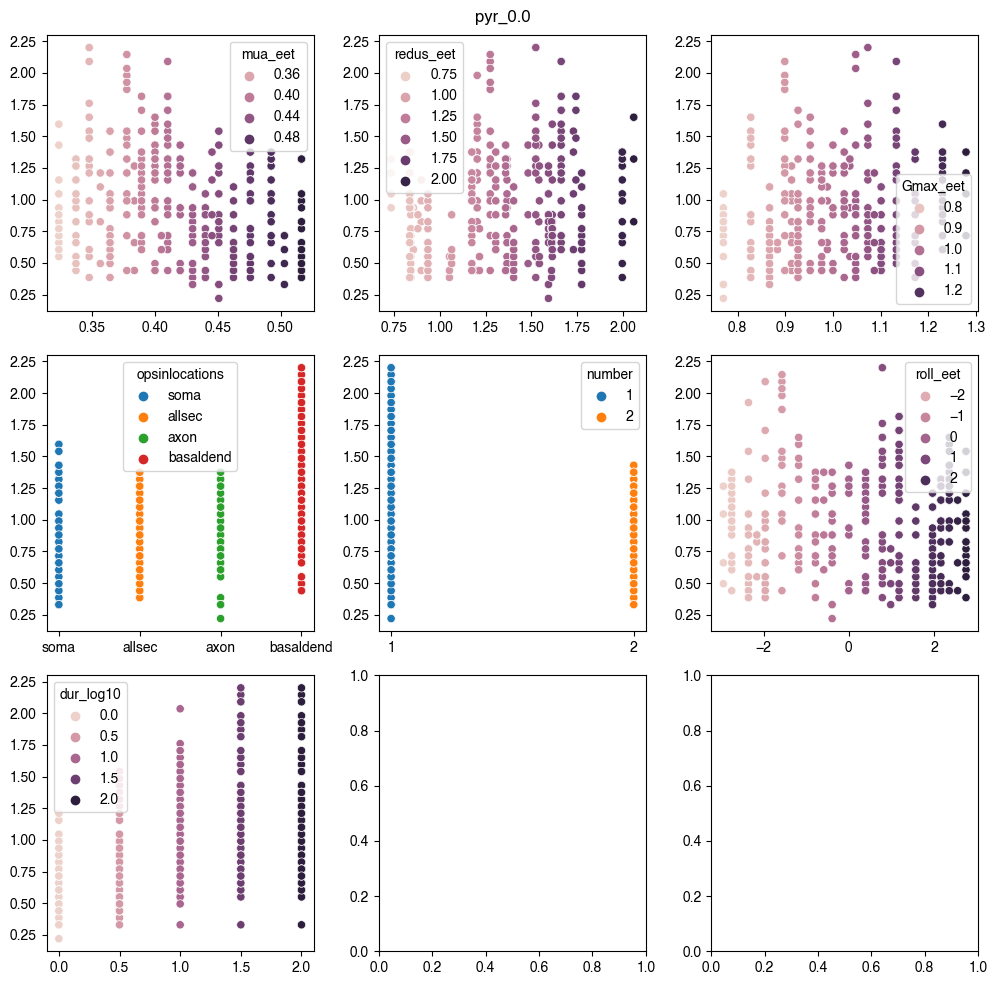

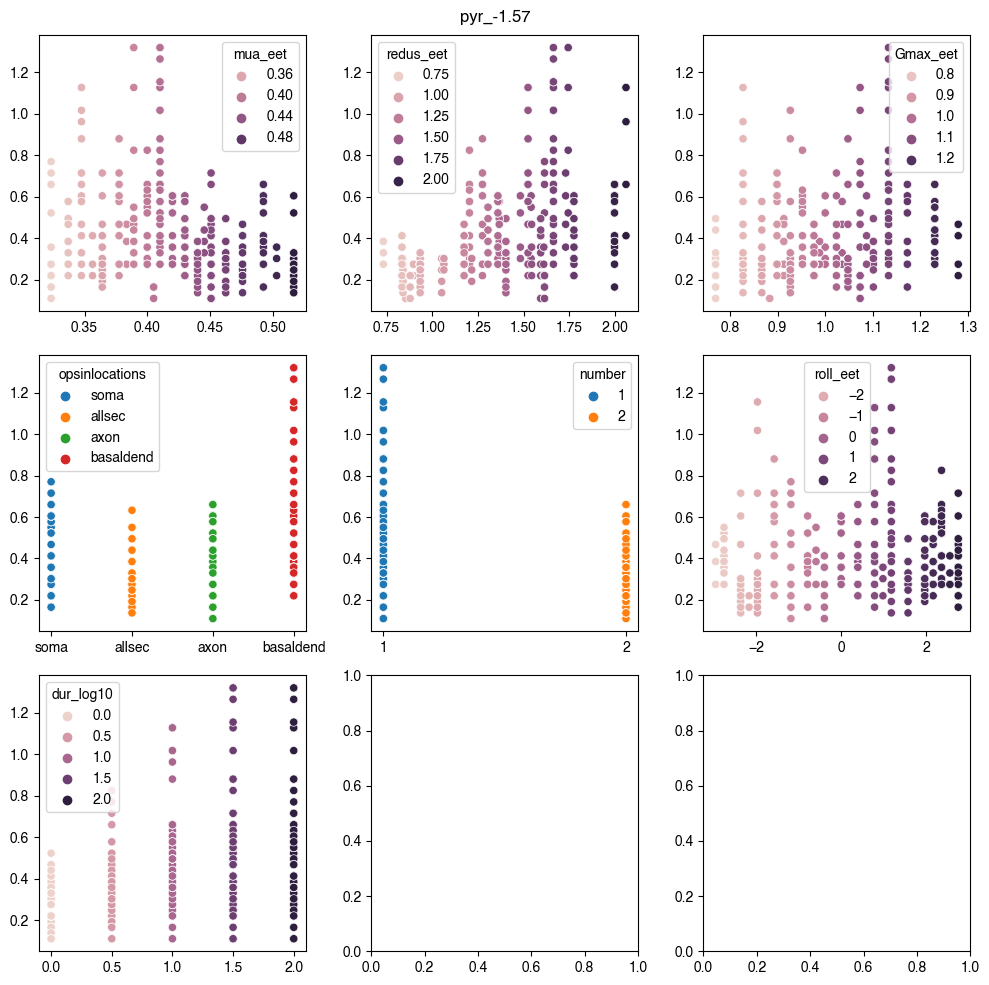

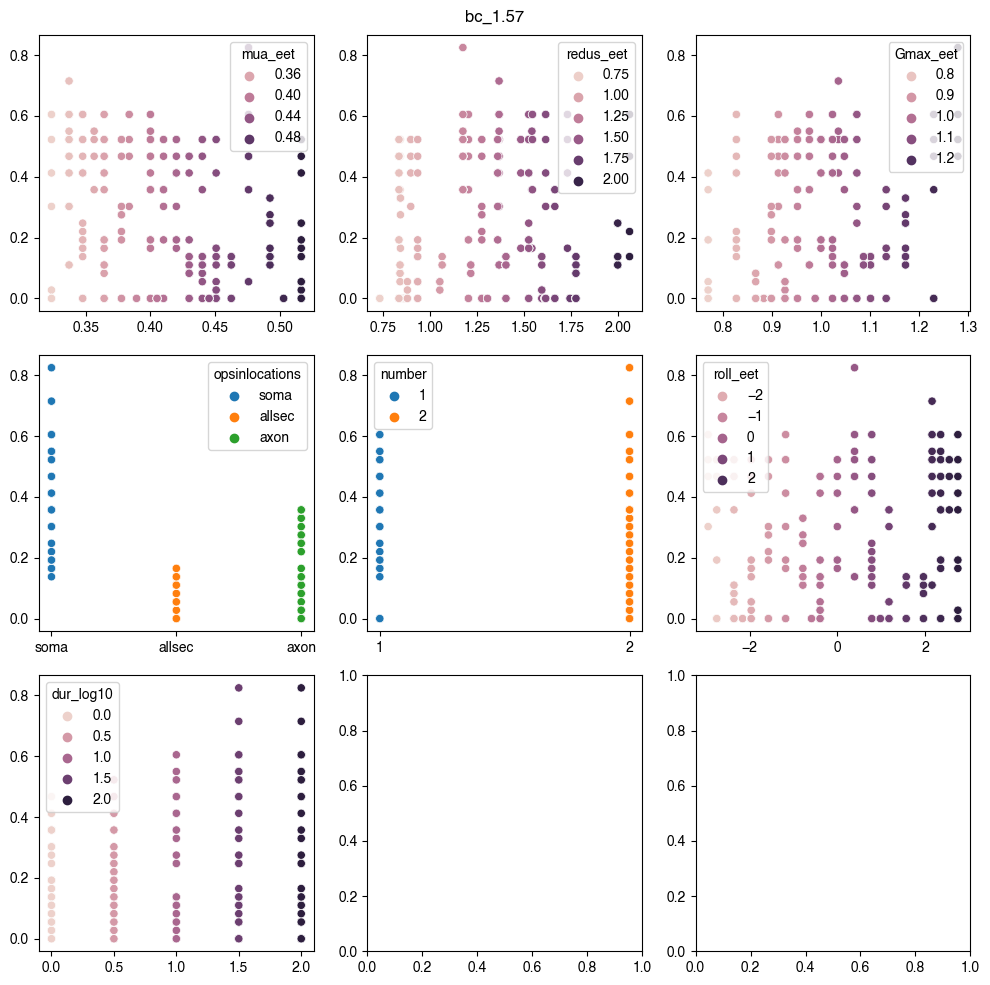

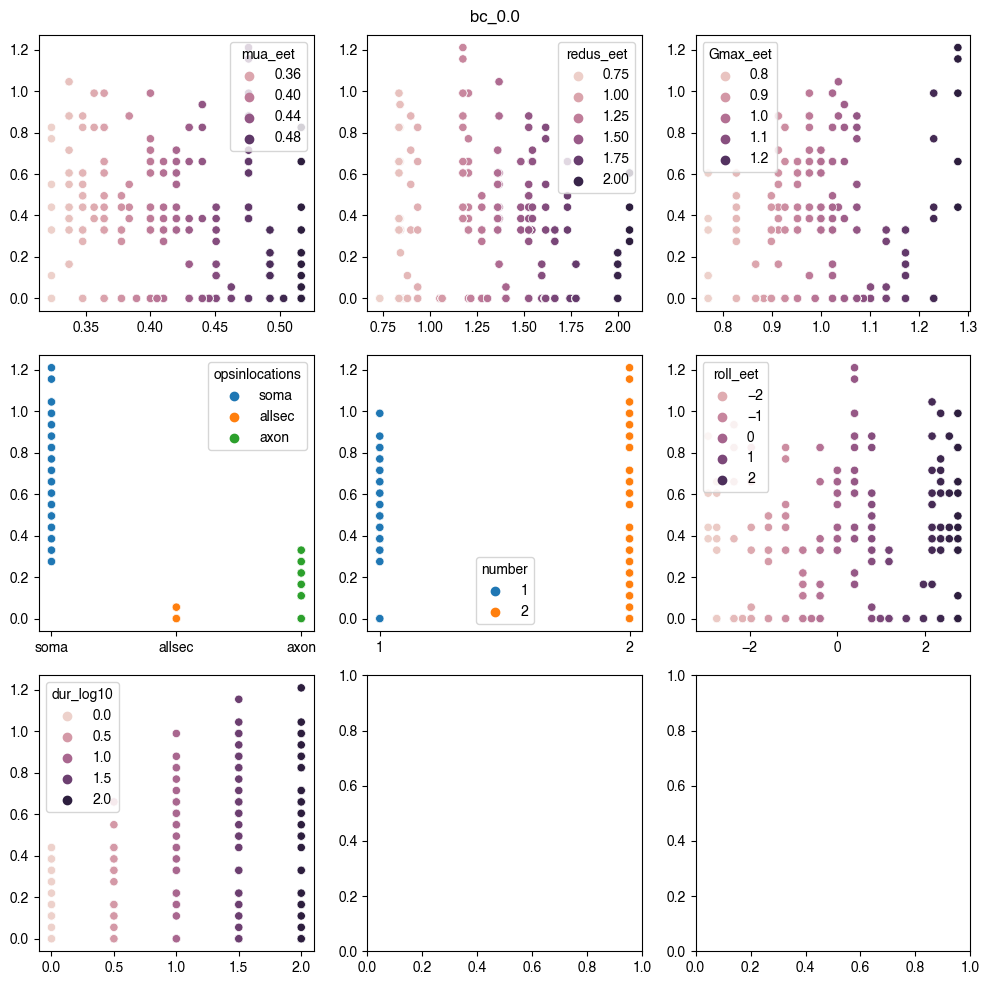

In [11]:
level = 10
uct_theta = vta_limit_df['ct_theta'].unique()
row_strs = ['mua_eet', 'redus_eet', 'Gmax_eet', 'opsinlocations', 'number' ,'roll_eet', 'dur_log10']
for cth in uct_theta:
    fig,axs = plt.subplots(np.ceil(len(row_strs)/3).astype(int),3, tight_layout=True, figsize=(10,10))
    for r, ax in zip(row_strs,axs.ravel()):
        idx = (vta_df['ct_theta']==cth) & (vta_df['level']==level)
        sns.scatterplot(data=vta_df[idx],x=r,y='surf_avg', hue=r, ax=ax)

        ax.set_xlabel(None)
        ax.set_ylabel(None)
    fig.suptitle(cth)


# Optimal/Worst Position

C:\Users\rschoete\AppData\Local\Temp\ipykernel_24236\362204863.py:141: RuntimeWarning: invalid value encountered in true_divide
  b_opt_dict[pitch][uk] = b_opt_dict[pitch][uk]/np.sum(b_opt_dict[pitch][uk],axis=0)
C:\Users\rschoete\AppData\Local\Temp\ipykernel_24236\362204863.py:142: RuntimeWarning: invalid value encountered in true_divide
  w_opt_dict[pitch][uk] = w_opt_dict[pitch][uk]/np.sum(w_opt_dict[pitch][uk],axis=0)
C:\Users\rschoete\AppData\Local\Temp\ipykernel_24236\362204863.py:203: RuntimeWarning: invalid value encountered in true_divide
  b_opt_dict[pitch][uk] = b_opt_dict[pitch][uk]/np.sum(b_opt_dict[pitch][uk],axis=0)
C:\Users\rschoete\AppData\Local\Temp\ipykernel_24236\362204863.py:204: RuntimeWarning: invalid value encountered in true_divide
  w_opt_dict[pitch][uk] = w_opt_dict[pitch][uk]/np.sum(w_opt_dict[pitch][uk],axis=0)
C:\Users\rschoete\AppData\Local\Temp\ipykernel_24236\362204863.py:203: RuntimeWarning: invalid value encountered in true_divide
  b_opt_dict[pitch][

b_opt_pos_TAC  w_opt_pos_TAC    dur opsinlocations neurontemplate  \
18               NaN            NaN    1.0           soma          pyr_1   
19              0.04           0.37    1.0           soma          pyr_1   
20              0.04           0.37    1.0           soma          pyr_1   
21              0.04           0.37    1.0           soma          pyr_1   
22              0.04           0.37    1.0           soma          pyr_1   
...              ...            ...    ...            ...            ...   
29650           0.04           0.70  100.0           soma          pyr_2   
29651           0.04           0.70  100.0           soma          pyr_2   
29652           0.15          -0.07  100.0           soma          pyr_2   
29653           0.15          -0.07  100.0           soma          pyr_2   
29654           0.15          -0.07  100.0           soma          pyr_2   

       theta_0     level   Gmax  selector  
18         0.0     0.100  1.000  pyr_soma  
19         0.0     0.316  1.000  pyr_soma  
20         0.0     1.000  1.000  pyr_soma  
21         0.0     3.162  1.000  pyr_soma  
22         0.0    10.000  1.000  pyr_soma  
...        ...       ...    ...       ...  
29650      0.0    10.000  0.867  pyr_soma  
29651      0.0    31.623  0.867  pyr_soma  
29652      0.0   100.000  0.867  pyr_soma  
29653      0.0   316.228  0.867  pyr_soma  
29654      0.0  1000.000  0.867  pyr_soma  

[1260 rows x 9 columns]

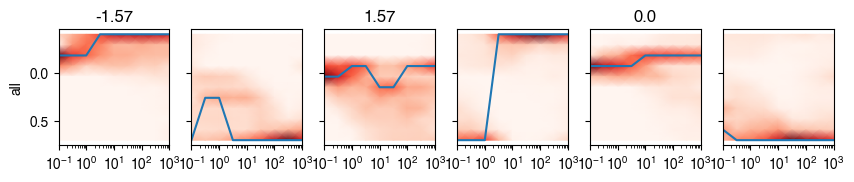

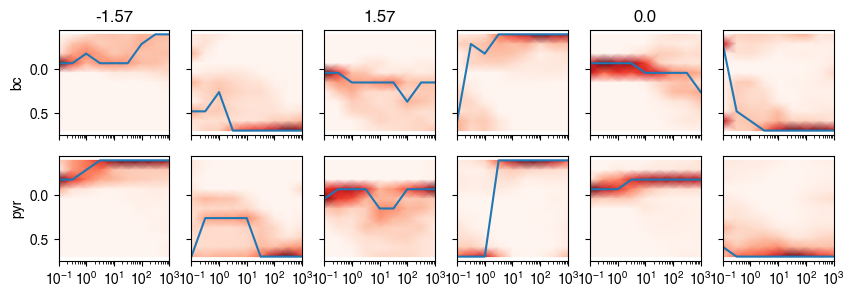

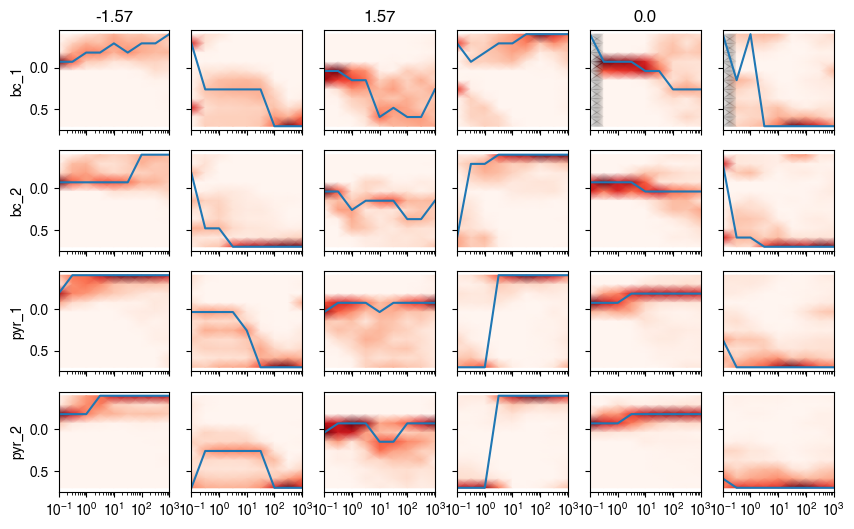

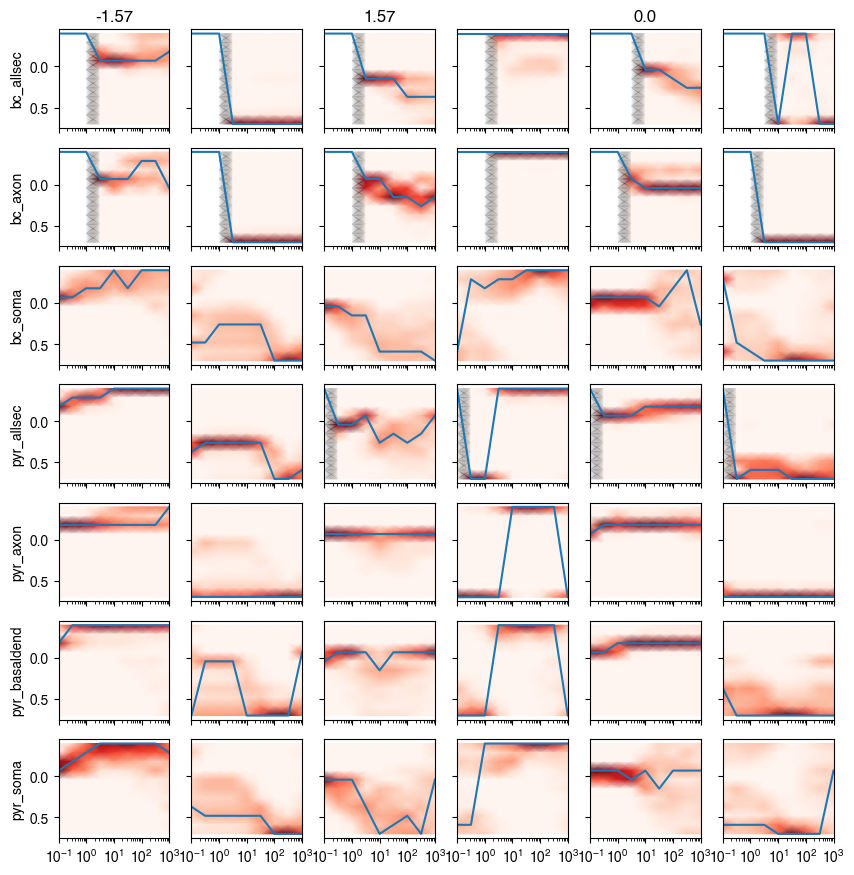

In [16]:
zpos = np.arange(-400,810,110)/1000
intensities = unique_values_columns_vta['level']
thetas = unique_values_columns_vta['theta_0']
ukeys = ['all']
columnsOI = ['b_opt_pos_TAC','w_opt_pos_TAC','dur','opsinlocations','neurontemplate','theta_0','level','Gmax']
b_opt_dict = {}
w_opt_dict = {}
for pitch in thetas:
    b_opt_dict[pitch] = {}
    w_opt_dict[pitch] = {}
    for uk in ukeys[:]:
        idx = (vta_limit_df['theta_0']==pitch)
        intm_df = vta_limit_df.loc[idx,columnsOI]
        b_opt_dict[pitch][uk]=np.zeros((len(zpos),len(intensities)))
        w_opt_dict[pitch][uk]=np.zeros((len(zpos),len(intensities)))
        for i, zp in enumerate(zpos):
            for j, ity in enumerate(intensities):
                idx = (intm_df['b_opt_pos_TAC']==zp) & (intm_df['level']==ity)
                b_opt_dict[pitch][uk][i,j] = np.sum(idx)

                idx = (intm_df['w_opt_pos_TAC']==zp) & (intm_df['level']==ity)
                w_opt_dict[pitch][uk][i,j] = np.sum(idx)

        b_opt_dict[pitch][uk] = b_opt_dict[pitch][uk]/np.sum(b_opt_dict[pitch][uk],axis=0)
        w_opt_dict[pitch][uk] = w_opt_dict[pitch][uk]/np.sum(w_opt_dict[pitch][uk],axis=0)

fig,axs = plt.subplots(len(ukeys),6,figsize=(10,1.5),sharex=True,sharey=True)
if len(ukeys)==1:
    axs = np.array([axs])
xX,yY = np.meshgrid(intensities,zpos)
for uk, axrow in zip(ukeys,axs):
    for i, theta in enumerate(thetas):
        axrow[i*2].pcolormesh(xX,yY,b_opt_dict[theta][uk],shading='gouraud',alpha=1,cmap='Reds')
        idx_max = np.argmax(b_opt_dict[theta][uk],axis=0)
        axrow[i*2].plot(intensities,zpos[idx_max])
        axrow[i*2].set_xscale('log')
        axrow[i*2].set_ylim([-0.45,0.750])

        axrow[i*2+1].pcolormesh(xX,yY,w_opt_dict[theta][uk],shading='gouraud',alpha=1,cmap='Reds')
        idx_max = np.argmax(w_opt_dict[theta][uk],axis=0)
        axrow[i*2+1].plot(intensities,zpos[idx_max])
        axrow[i*2+1].set_xscale('log')
        axrow[i*2+1].set_ylim([-0.45,0.750])
        axrow[i*2].invert_yaxis()
        axrow[i*2+1].invert_yaxis()

        if uk==ukeys[0]:
            axrow[i*2].set_title(theta)
    axrow[0].set_ylabel(uk)

axs[0,0].invert_yaxis()

#################### celltype split#################################
####################################################################

zpos = np.arange(-400,810,110)/1000
intensities = unique_values_columns_vta['level']
thetas = unique_values_columns_vta['theta_0']
vta_limit_df['selector'] = vta_limit_df.apply(lambda x: f"{x['celltype']}",axis=1)
ukeys = vta_limit_df['selector'].unique()
columnsOI = ['b_opt_pos_TAC','w_opt_pos_TAC','dur','opsinlocations','neurontemplate','theta_0','level','Gmax','selector']
b_opt_dict = {}
w_opt_dict = {}
for pitch in thetas:
    b_opt_dict[pitch] = {}
    w_opt_dict[pitch] = {}
    for uk in ukeys[:]:
        idx = (vta_limit_df['selector']==uk) & (vta_limit_df['theta_0']==pitch)
        intm_df = vta_limit_df.loc[idx,columnsOI]
        b_opt_dict[pitch][uk]=np.zeros((len(zpos),len(intensities)))
        w_opt_dict[pitch][uk]=np.zeros((len(zpos),len(intensities)))
        for i, zp in enumerate(zpos):
            for j, ity in enumerate(intensities):
                idx = (intm_df['b_opt_pos_TAC']==zp) & (intm_df['level']==ity)
                b_opt_dict[pitch][uk][i,j] = np.sum(idx)

                idx = (intm_df['w_opt_pos_TAC']==zp) & (intm_df['level']==ity)
                w_opt_dict[pitch][uk][i,j] = np.sum(idx)

        b_opt_dict[pitch][uk] = b_opt_dict[pitch][uk]/np.sum(b_opt_dict[pitch][uk],axis=0)
        w_opt_dict[pitch][uk] = w_opt_dict[pitch][uk]/np.sum(w_opt_dict[pitch][uk],axis=0)




vta_limit_df.drop(columns=['selector'])


fig,axs = plt.subplots(len(ukeys),6,figsize=(10,3),sharex=True,sharey=True)
xX,yY = np.meshgrid(intensities,zpos)
for uk, axrow in zip(ukeys,axs):
    for i, theta in enumerate(thetas):
        axrow[i*2].pcolormesh(xX,yY,b_opt_dict[theta][uk],shading='gouraud',alpha=1,cmap='Reds')
        idx_max = np.argmax(b_opt_dict[theta][uk],axis=0)
        axrow[i*2].plot(intensities,zpos[idx_max])
        axrow[i*2].set_xscale('log')
        axrow[i*2].set_ylim([-0.45,0.750])

        axrow[i*2+1].pcolormesh(xX,yY,w_opt_dict[theta][uk],shading='gouraud',alpha=1,cmap='Reds')
        idx_max = np.argmax(w_opt_dict[theta][uk],axis=0)
        axrow[i*2+1].plot(intensities,zpos[idx_max])
        axrow[i*2+1].set_xscale('log')
        axrow[i*2+1].set_ylim([-0.45,0.750])
        axrow[i*2].invert_yaxis()
        axrow[i*2+1].invert_yaxis()

        if uk==ukeys[0]:
            axrow[i*2].set_title(theta)
    axrow[0].set_ylabel(uk)

axs[0,0].invert_yaxis()


#################### neuron type split #################################
####################################################################

zpos = np.arange(-400,810,110)/1000
intensities = unique_values_columns_vta['level']
thetas = unique_values_columns_vta['theta_0']
vta_limit_df['selector'] = vta_limit_df.apply(lambda x: f"{x['neurontemplate']}",axis=1)
ukeys = np.sort(vta_limit_df['selector'].unique())
columnsOI = ['b_opt_pos_TAC','w_opt_pos_TAC','dur','opsinlocations','neurontemplate','theta_0','level','Gmax','selector']
b_opt_dict = {}
w_opt_dict = {}
for pitch in thetas:
    b_opt_dict[pitch] = {}
    w_opt_dict[pitch] = {}
    for uk in ukeys[:]:
        idx = (vta_limit_df['selector']==uk) & (vta_limit_df['theta_0']==pitch)
        intm_df = vta_limit_df.loc[idx,columnsOI]
        b_opt_dict[pitch][uk]=np.zeros((len(zpos),len(intensities)))
        w_opt_dict[pitch][uk]=np.zeros((len(zpos),len(intensities)))
        for i, zp in enumerate(zpos):
            for j, ity in enumerate(intensities):
                idx = (intm_df['b_opt_pos_TAC']==zp) & (intm_df['level']==ity)
                b_opt_dict[pitch][uk][i,j] = np.sum(idx)

                idx = (intm_df['w_opt_pos_TAC']==zp) & (intm_df['level']==ity)
                w_opt_dict[pitch][uk][i,j] = np.sum(idx)

        b_opt_dict[pitch][uk] = b_opt_dict[pitch][uk]/np.sum(b_opt_dict[pitch][uk],axis=0)
        w_opt_dict[pitch][uk] = w_opt_dict[pitch][uk]/np.sum(w_opt_dict[pitch][uk],axis=0)




vta_limit_df.drop(columns=['selector'])


fig,axs = plt.subplots(len(ukeys),6,figsize=(10,6),sharex=True,sharey=True)
xX,yY = np.meshgrid(intensities,zpos)
for uk, axrow in zip(ukeys,axs):
    for i, theta in enumerate(thetas):
        axrow[i*2].pcolormesh(xX,yY,b_opt_dict[theta][uk],shading='gouraud',alpha=1,cmap='Reds')
        idx_max = np.argmax(b_opt_dict[theta][uk],axis=0)
        axrow[i*2].plot(intensities,zpos[idx_max])
        axrow[i*2].set_xscale('log')
        axrow[i*2].set_ylim([-0.45,0.750])

        axrow[i*2+1].pcolormesh(xX,yY,w_opt_dict[theta][uk],shading='gouraud',alpha=1,cmap='Reds')
        idx_max = np.argmax(w_opt_dict[theta][uk],axis=0)
        axrow[i*2+1].plot(intensities,zpos[idx_max])
        axrow[i*2+1].set_xscale('log')
        axrow[i*2+1].set_ylim([-0.45,0.750])
        axrow[i*2].invert_yaxis()
        axrow[i*2+1].invert_yaxis()

        if uk==ukeys[0]:
            axrow[i*2].set_title(theta)
    axrow[0].set_ylabel(uk)

axs[0,0].invert_yaxis()


#################### opsin and celltype split#################################
####################################################################

zpos = np.arange(-400,810,110)/1000
intensities = unique_values_columns_vta['level']
thetas = unique_values_columns_vta['theta_0']
vta_limit_df['selector'] = vta_limit_df.apply(lambda x: f"{x['celltype']}_{x['opsinlocations']}",axis=1)
#vta_limit_df['selector'] = vta_limit_df.apply(lambda x: f"{x['opsinlocations']}",axis=1)
ukeys = np.sort(vta_limit_df['selector'].unique())
columnsOI = ['b_opt_pos_TAC','w_opt_pos_TAC','dur','opsinlocations','neurontemplate','theta_0','level','Gmax','selector']
b_opt_dict = {}
w_opt_dict = {}
for pitch in thetas:
    b_opt_dict[pitch] = {}
    w_opt_dict[pitch] = {}
    for uk in ukeys[:]:
        idx = (vta_limit_df['selector']==uk) & (vta_limit_df['theta_0']==pitch)
        intm_df = vta_limit_df.loc[idx,columnsOI]
        b_opt_dict[pitch][uk]=np.zeros((len(zpos),len(intensities)))
        w_opt_dict[pitch][uk]=np.zeros((len(zpos),len(intensities)))
        for i, zp in enumerate(zpos):
            for j, ity in enumerate(intensities):
                idx = (intm_df['b_opt_pos_TAC']==zp) & (intm_df['level']==ity)
                b_opt_dict[pitch][uk][i,j] = np.sum(idx)

                idx = (intm_df['w_opt_pos_TAC']==zp) & (intm_df['level']==ity)
                w_opt_dict[pitch][uk][i,j] = np.sum(idx)

        b_opt_dict[pitch][uk] = b_opt_dict[pitch][uk]/np.sum(b_opt_dict[pitch][uk],axis=0)
        w_opt_dict[pitch][uk] = w_opt_dict[pitch][uk]/np.sum(w_opt_dict[pitch][uk],axis=0)







fig,axs = plt.subplots(len(ukeys),6,figsize=(10,1.5*7),sharex=True,sharey=True)
xX,yY = np.meshgrid(intensities,zpos)
for uk, axrow in zip(ukeys,axs):
    for i, theta in enumerate(thetas):
        axrow[i*2].pcolormesh(xX,yY,b_opt_dict[theta][uk],shading='gouraud',alpha=1,cmap='Reds')
        idx_max = np.argmax(b_opt_dict[theta][uk],axis=0)
        axrow[i*2].plot(intensities,zpos[idx_max])
        axrow[i*2].set_xscale('log')
        axrow[i*2].set_ylim([-0.45,0.750])

        axrow[i*2+1].pcolormesh(xX,yY,w_opt_dict[theta][uk],shading='gouraud',alpha=1,cmap='Reds')
        idx_max = np.argmax(w_opt_dict[theta][uk],axis=0)
        axrow[i*2+1].plot(intensities,zpos[idx_max])
        axrow[i*2+1].set_xscale('log')
        axrow[i*2+1].set_ylim([-0.45,0.750])
        axrow[i*2].invert_yaxis()
        axrow[i*2+1].invert_yaxis()

        if uk==ukeys[0]:
            axrow[i*2].set_title(theta)
    axrow[0].set_ylabel(uk)

axs[0,0].invert_yaxis()
intm_df

# EET

In [17]:
r=int(16)
# detect false calculated EET (check opsinloc and morpho)
columnsOI=['surf_avg','EETsimidx', 'mua_eet', 'redus_eet','Gmax_eet', 'cell_eet', 'loc_eet', 'roll_eet','opsinlocations','number','cluster_eet','idx_incluster_eet']
false_sims = {}
for celltype in ['pyr', 'bc']:
    for th in unique_values_columns_vta['theta_0']:
        false_sims[f"{celltype}_{th}"]=[]
        intm_df = vta_df.loc[selection_generator(vta_df,unique_values_columns_vta,dur=10,level=10,ct_theta=f"{celltype}_{th}"), columnsOI].copy()
        if celltype == 'pyr':
            intm_df['loc_eet'] = np.floor(intm_df['loc_eet']/3).astype(int)
        elif celltype == 'bc':
            intm_df['loc_eet'] = np.floor(intm_df['loc_eet']/4).astype(int)
        else:
            raise ValueError('celltype is false')
        intm_df = intm_df.sort_values(by=['EETsimidx'])
        print(celltype,th)
        for ic in range(r):
            mydata = intm_df[intm_df['cluster_eet']==ic].copy().set_index('idx_incluster_eet')
            for i, param in enumerate(['mua_eet', 'redus_eet','Gmax_eet', 'cell_eet', 'loc_eet', 'roll_eet']):
                center_param = mydata.loc[0,param]
                step_param = mydata.loc[i+1,param]
                if center_param==step_param:
                    false_sims[f"{celltype}_{th}"].append(mydata.loc[i+1,'EETsimidx'])
false_sims


pyr -1.57
pyr 1.57
pyr 0.0
bc -1.57
bc 1.57
bc 0.0


{'pyr_-1.57': [4.0,
  5.0,
  12.0,
  19.0,
  25.0,
  32.0,
  39.0,
  46.0,
  54.0,
  61.0,
  81.0,
  82.0,
  88.0,
  89.0,
  95.0,
  102.0,
  109.0],
 'pyr_1.57': [4.0,
  5.0,
  12.0,
  19.0,
  25.0,
  32.0,
  39.0,
  46.0,
  54.0,
  61.0,
  81.0,
  82.0,
  88.0,
  89.0,
  95.0,
  102.0,
  109.0],
 'pyr_0.0': [4.0,
  5.0,
  12.0,
  19.0,
  25.0,
  32.0,
  39.0,
  46.0,
  54.0,
  61.0,
  81.0,
  82.0,
  88.0,
  89.0,
  95.0,
  102.0,
  109.0],
 'bc_-1.57': [4.0,
  5.0,
  12.0,
  25.0,
  32.0,
  39.0,
  46.0,
  61.0,
  81.0,
  82.0,
  88.0,
  89.0,
  95.0,
  102.0,
  109.0],
 'bc_1.57': [4.0,
  5.0,
  12.0,
  25.0,
  32.0,
  39.0,
  46.0,
  61.0,
  81.0,
  82.0,
  88.0,
  89.0,
  95.0,
  102.0,
  109.0],
 'bc_0.0': [4.0,
  5.0,
  12.0,
  25.0,
  32.0,
  39.0,
  46.0,
  61.0,
  81.0,
  82.0,
  88.0,
  89.0,
  95.0,
  102.0,
  109.0]}

In [18]:
vta_df_nocellloc = vta_df.copy()
cellidx = 4+np.arange(r)*7
locidx = 5+np.arange(r)*7
vta_df_nocellloc=vta_df_nocellloc.set_index('EETsimidx')
vta_df_nocellloc=vta_df_nocellloc.drop(index=np.concatenate((cellidx,locidx)))
vta_df_nocellloc = vta_df_nocellloc.reset_index()
vta_df_nocellloc.drop(columns=['loc_eet','cell_eet'])
vta_df_nocellloc

EETsimidx    vta_low     vta_up  surf_low  surf_up  b_opt_pos  \
0            0.0   0.000000   0.000000     0.000    0.000        NaN   
1            0.0   0.000000   0.000000     0.000    0.000        NaN   
2            0.0   0.000000   0.064795     0.000    0.220      -0.07   
3            0.0   0.000000   0.086394     0.000    0.275      -0.07   
4            0.0   0.000000   0.086394     0.000    0.275      -0.07   
...          ...        ...        ...       ...      ...        ...   
21595       99.0   0.010799   0.161988     0.000    0.385      -0.40   
21596       99.0   0.172788   0.626355     0.220    0.770      -0.40   
21597       99.0   1.403899   2.937389     1.045    2.035      -0.40   
21598       99.0   5.237624   8.736573     2.585    3.905      -0.40   
21599       99.0  12.224722  18.164296     4.070    5.610      -0.40   

       b_opt_pos_TAC  w_opt_pos_TAC  b_opt_pos_TACamp  w_opt_pos_TACamp  ...  \
0                NaN            NaN               NaN               NaN  ...   
1                NaN            NaN               NaN               NaN  ...   
2              -0.29           0.26             -0.29             -0.40  ...   
3              -0.29           0.26             -0.40              0.04  ...   
4              -0.29           0.26             -0.40              0.04  ...   
...              ...            ...               ...               ...  ...   
21595          -0.40           0.70             -0.40              0.04  ...   
21596          -0.40           0.70             -0.40              0.15  ...   
21597          -0.40           0.70             -0.40              0.59  ...   
21598          -0.40           0.70             -0.40              0.70  ...   
21599          -0.40           0.70              0.15              0.70  ...   

       dur_log10  Gmax_log10  level_log10 surf_avg_log10  celltype  number  \
0            0.0      0.0000      -1.0000           -inf        bc       1   
1            0.0      0.0000      -0.5003           -inf        bc       1   
2            0.0      0.0000       0.0000        -1.0835        bc       1   
3            0.0      0.0000       0.5000        -0.9586        bc       1   
4            0.0      0.0000       1.0000        -0.9586        bc       1   
...          ...         ...          ...            ...       ...     ...   
21595        2.0      0.0306       1.0000        -0.7825       pyr       1   
21596        2.0      0.0306       1.5000        -0.3302       pyr       1   
21597        2.0      0.0306       2.0000         0.1797       pyr       1   
21598        2.0      0.0306       2.5000         0.5075       pyr       1   
21599        2.0      0.0306       3.0000         0.6824       pyr       1   

        ct_theta  redus_eet cluster_eet  idx_incluster_eet  
0       bc_-1.57   1.359600         0.0                0.0  
1       bc_-1.57   1.359600         0.0                0.0  
2       bc_-1.57   1.359600         0.0                0.0  
3       bc_-1.57   1.359600         0.0                0.0  
4       bc_-1.57   1.359600         0.0                0.0  
...          ...        ...         ...                ...  
21595  pyr_-1.57   1.614587        14.0                1.0  
21596  pyr_-1.57   1.614587        14.0                1.0  
21597  pyr_-1.57   1.614587        14.0                1.0  
21598  pyr_-1.57   1.614587        14.0                1.0  
21599  pyr_-1.57   1.614587        14.0                1.0  

[21600 rows x 49 columns]

In [19]:
vta_df.columns

Index(['vta_low', 'vta_up', 'surf_low', 'surf_up', 'b_opt_pos',
       'b_opt_pos_TAC', 'w_opt_pos_TAC', 'b_opt_pos_TACamp',
       'w_opt_pos_TACamp', 'dur', 'level', 'theta_0', 'neurontemplate', 'x_0',
       'y_0', 'z_0', 'Gmax', 'opsinlocations', 'phi', 'theta', 'psi', 'phi_0',
       'psi_0', 'celsius', 'dt', 'EETsimidx', 'mua_eet', 'mus_eet', 'g_eet',
       'Gmax_eet', 'cell_eet', 'loc_eet', 'roll_eet', 'settings_str',
       'surf_avg', 'vta_low_log10', 'vta_up_log10', 'surf_low_log10',
       'surf_up_log10', 'dur_log10', 'Gmax_log10', 'level_log10',
       'surf_avg_log10', 'celltype', 'number', 'ct_theta', 'redus_eet',
       'cluster_eet', 'idx_incluster_eet'],
      dtype='object')

mi     sigma                                                 EE  \
0     0.000000  0.000000  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1     0.000000  0.000000  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2     0.000000  0.000000  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3     0.000000  0.000000  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4     0.000000  0.000000  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...        ...       ...                                                ...   
1075  0.071169  0.123866  [0.0, 0.39874999999999955, 0.0, 0.0, 0.2658333...   
1076  0.771844  1.527615  [0.0, 1.4226759313019213, 0.0, 7.3221501835883...   
1077  0.471387  0.660559  [0.0, 0.8608269167886761, 0.0, 1.7311395949422...   
1078  1.269001  1.508545  [0.0, 4.197576685101783, 0.0, 0.30251121336702...   
1079  0.054702  0.128825  [0.0, 0.0, 0.0, 0.0, 0.5316666666666683, 0.0, ...   

         mi_sd  sigma_sd     mi_lb  sigma_lb     mi_ub  sigma_ub  \
0          0.0       0.0       0.0       0.0       0.0       0.0   
1          0.0       0.0       0.0       0.0       0.0       0.0   
2          0.0       0.0       0.0       0.0       0.0       0.0   
3          0.0       0.0       0.0       0.0       0.0       0.0   
4          0.0       0.0       0.0       0.0       0.0       0.0   
...        ...       ...       ...       ...       ...       ...   
1075  0.032268  0.029499  0.016615  0.047954  0.139411   0.16904   
1076  0.456808  0.834409  0.148595  0.290739  1.774989    2.8181   
1077  0.177944  0.102398  0.161405  0.414263  0.839272  0.802326   
1078  0.392062  0.285483  0.575289  0.797915   2.08865  1.981055   
1079  0.037059  0.060857       0.0       0.0  0.132917  0.215042   

                                                 mi_all  \
0                                  [0.0, 0.0, 0.0, 0.0]   
1                                  [0.0, 0.0, 0.0, 0.0]   
2                                  [0.0, 0.0, 0.0, 0.0]   
3                                  [0.0, 0.0, 0.0, 0.0]   
4                [0.0, 0.0, 0.0028902064844448525, 0.0]   
...                                                 ...   
1075  [0.39759187503884813, 0.32943096571272656, 1.3...   
1076  [2.3717280854034613, 0.7475402782411702, 1.032...   
1077  [0.28411971964392707, 0.535573853733423, 0.785...   
1078  [0.5966738449087673, 0.381474618655731, 1.9841...   
1079  [0.1483603055377738, 0.1983995189266218, 1.004...   

                                              sigma_all  order_mean  \
0                                  [0.0, 0.0, 0.0, 0.0]         NaN   
1                                  [0.0, 0.0, 0.0, 0.0]         NaN   
2                                  [0.0, 0.0, 0.0, 0.0]         NaN   
3                                  [0.0, 0.0, 0.0, 0.0]         NaN   
4                   [0.0, 0.0, 0.0111937215813556, 0.0]         0.0   
...                                                 ...         ...   
1075  [0.5327464648254587, 0.37111544151667786, 1.20...         0.0   
1076  [3.3482108326500297, 0.8341258221048383, 1.508...         2.0   
1077  [0.39872408768108897, 0.7466311559228967, 1.15...         1.0   
1078  [0.5195281819778363, 0.5606303081583268, 1.530...         3.0   
1079  [0.2875822654694088, 0.5018467522793664, 1.286...         0.0   

      order_std      label    dur     level celltype theta_0 number  
0           NaN    mua_eet    1.0     0.100       bc   -1.57      1  
1           NaN  redus_eet    1.0     0.100       bc   -1.57      1  
2           NaN   Gmax_eet    1.0     0.100       bc   -1.57      1  
3           NaN   roll_eet    1.0     0.100       bc   -1.57      1  
4           0.0    mua_eet    1.0     0.316       bc   -1.57      1  
...         ...        ...    ...       ...      ...     ...    ...  
1075        0.0   roll_eet  100.0   316.228       bc     0.0      1  
1076        3.0    mua_eet  100.0  1000.000       bc     0.0      1  
1077        1.0  redus_eet  100.0  1000.000       bc  

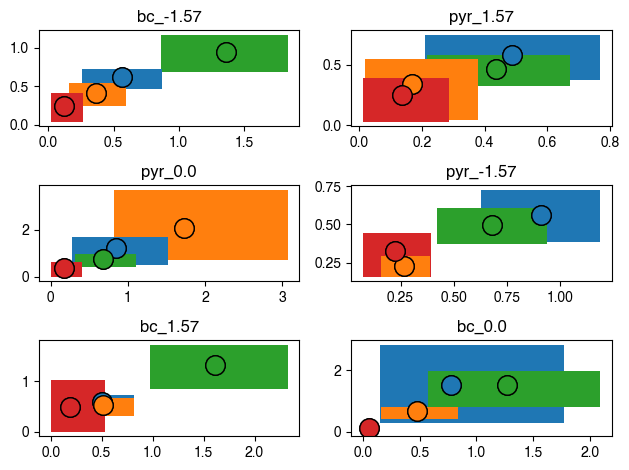

In [20]:
EET_pallete = {'mua_eet':'tab:blue','redus_eet':'tab:orange','Gmax_eet':'tab:green','roll_eet':'tab:red'}
def get_importance(mylist):
    'unique gets unique and sorts'
    if all(mylist==0):
        return np.full(len(mylist),np.nan)
    u,idx = np.unique(mylist,return_inverse=True)
    if max(idx)<(len(mylist)-1):
        idx += len(mylist)-1-max(idx)
    idx_0 = mylist==0
    idx[idx_0]=0
    return idx
EETs = {}
idx = -1
labels_eet = ['mua_eet',	'redus_eet',	'Gmax_eet',	'roll_eet']
fig,axs = plt.subplots(3,2, tight_layout=True)
for ctth,ax in zip(unique_values_columns_vta['ct_theta'],axs.ravel()):
    for dur in unique_values_columns_vta['dur']:
        for lvl in unique_values_columns_vta['level']:

            #columnsOI=['surf_avg','EETsimidx', 'mua_eet', 'redus_eet','Gmax_eet', 'cell_eet', 'loc_eet', 'roll_eet','opsinlocations','number']
            columnsOI=['surf_avg','EETsimidx', 'mua_eet', 'redus_eet','Gmax_eet', 'roll_eet','opsinlocations','number','celltype','theta_0','level','dur']
            intm_df = vta_df_nocellloc.loc[selection_generator(vta_df_nocellloc,unique_values_columns_vta,dur=dur,level=lvl,ct_theta=ctth),columnsOI].copy()
            intm_df = intm_df.sort_values(by=['EETsimidx'])

            X = intm_df[['mua_eet',	'redus_eet',	'Gmax_eet',	'roll_eet']].values
            Y = intm_df['surf_avg'].values
            xmin = np.min(X,axis=0)
            xmax = np.max(X,axis=0)
            mi, sigma, EE, mi_sd, sigma_sd, mi_lb, sigma_lb, mi_ub, sigma_ub, mi_all, sigma_all = EET_indices(r, xmin, xmax, X, Y, design_type='radial', Nboot=1000)

            order_mean = get_importance(mi)
            order_std = get_importance(sigma)

            for i,label in enumerate(labels_eet):
                idx+=1
                EETs[idx] = dict(mi=mi[i], sigma=sigma[i], EE=EE[:,i], mi_sd=mi_sd[i], sigma_sd=sigma_sd[i], mi_lb=mi_lb[i], sigma_lb=sigma_lb[i], mi_ub=mi_ub[i], sigma_ub=sigma_ub[i], mi_all=mi_all[i], sigma_all=sigma_all[i], order_mean=order_mean[i],order_std=order_std[i], label=label, dur=dur, level=lvl, celltype = intm_df['celltype'].iloc[0],theta_0 = intm_df['theta_0'].iloc[0], number = intm_df['number'].iloc[0])
    EET_plot(mi,sigma,labels_eet,mi_lb,mi_ub,sigma_lb,sigma_ub,ax=ax)
    ax.set_title(ctth)
EET_surfavgdf = pd.DataFrame(EETs).T
EET_surfavgdf=EET_surfavgdf.astype({'mi': 'float','sigma': 'float','order_mean':'float','order_std':'float','label':'str','dur':'float','level':'float'})
EET_surfavgdf

In [21]:
EET_surfavgdf['order_mean'].count()

1040

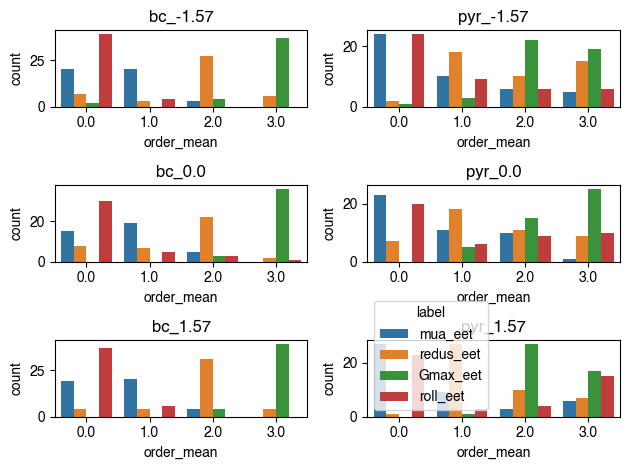

In [22]:
EET_surfavgdf['ct_theta'] = EET_surfavgdf.apply(lambda row: f"{row['celltype']}_{row['theta_0']}", axis=1)
fig,axs = plt.subplots(3,2, tight_layout=True)
for ctth,ax in zip(np.sort(unique_values_columns_vta['ct_theta']),axs.T.ravel()):
    idx = EET_surfavgdf['ct_theta'] == ctth
    sns.countplot(EET_surfavgdf[idx],x='order_mean', hue='label', palette=EET_pallete,ax=ax)
    ax.set_title(ctth)
for ax in axs.ravel()[:-1]:
    ax.get_legend().remove()


c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 6.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 9.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 13.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 9.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\rs

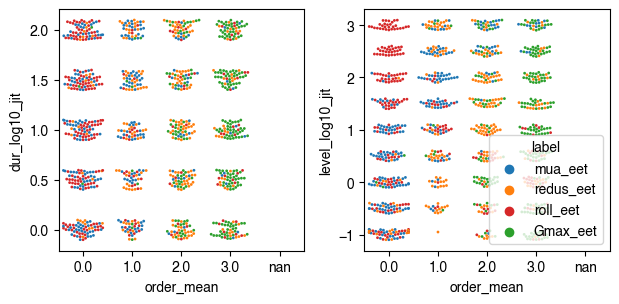

c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 21.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 24.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\r

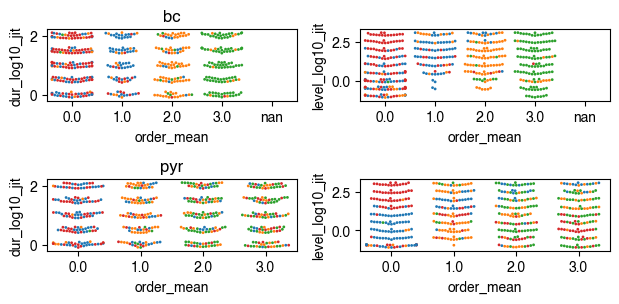

In [25]:
w=2
EET_surfavgdf['ct_theta'] = EET_surfavgdf.apply(lambda row: f"{row['celltype']}_{row['theta_0']}", axis=1)
EET_surfavgdf['dur_log10'] = np.log10(EET_surfavgdf['dur'])
EET_surfavgdf['level_log10'] = np.log10(EET_surfavgdf['level'])
EET_surfavgdf['dur_log10_jit'] = EET_surfavgdf['dur_log10']+(np.random.rand(len(EET_surfavgdf['dur_log10']))-0.5)*0.2
EET_surfavgdf['level_log10_jit'] = EET_surfavgdf['level_log10']+(np.random.rand(len(EET_surfavgdf['level_log10']))-0.5)*0.2
fig,axs = plt.subplots(1,2, tight_layout=True, figsize=(16/2.54,8/2.54))
axs = np.array([axs])
for ctth,axrow in zip(np.sort(unique_values_columns_vta['ct_theta']),axs):
    sns.swarmplot(data=EET_surfavgdf,x='order_mean',y='dur_log10_jit',hue='label',ax=axrow[0],size=w, palette=EET_pallete)
    sns.swarmplot(data=EET_surfavgdf,x='order_mean',y='level_log10_jit',hue='label',ax=axrow[1],size=w, palette=EET_pallete)
try:
    for ax in axs.ravel()[:-1]:
        ax.get_legend().remove()
except:
    pass

w=2
fig,axs = plt.subplots(2,2, tight_layout=True, figsize=(16/2.54,8/2.54))
for ctth,axrow in zip(np.sort(unique_values_columns_vta['celltype']),axs):
    idx = EET_surfavgdf['celltype'] == ctth
    sns.swarmplot(data=EET_surfavgdf[idx],x='order_mean',y='dur_log10_jit',hue='label',ax=axrow[0],size=w, palette=EET_pallete)
    sns.swarmplot(data=EET_surfavgdf[idx],x='order_mean',y='level_log10_jit',hue='label',ax=axrow[1],size=w, palette=EET_pallete)
    axrow[0].set_title(ctth)
try:
    for ax in axs.ravel():
        ax.get_legend().remove()
except:
    pass

c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 6.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 7.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\seaborn\categorical.py:3544: UserWa

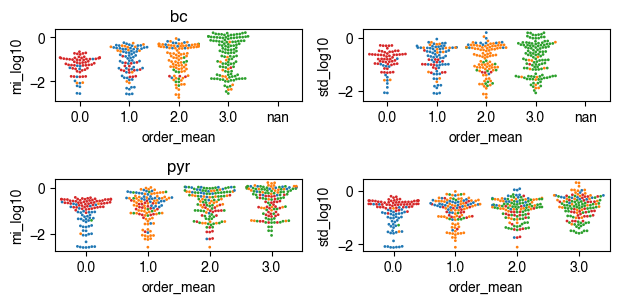

In [24]:
EET_pallete = {'mua_eet':'tab:blue','redus_eet':'tab:orange','Gmax_eet':'tab:green','roll_eet':'tab:red'}
EET_surfavgdf['mi_log10'] = np.log10(EET_surfavgdf['mi'])
EET_surfavgdf['std_log10'] = np.log10(EET_surfavgdf['sigma'])
fig,axs = plt.subplots(2,2, tight_layout=True, figsize=(16/2.54,8/2.54))
for ctth,axrow in zip(np.sort(unique_values_columns_vta['celltype']),axs):
    idx = EET_surfavgdf['celltype'] == ctth
    sns.swarmplot(data=EET_surfavgdf[idx],x='order_mean',y='mi_log10',hue='label',ax=axrow[0],size=w, palette=EET_pallete)
    sns.swarmplot(data=EET_surfavgdf[idx],x='order_mean',y='std_log10',hue='label',ax=axrow[1],size=w, palette=EET_pallete)
    axrow[0].set_title(ctth)
try:
    for ax in axs.ravel():
        ax.get_legend().remove()
except:
    pass